# Anti-Money Laundering (AML) Transaction Monitoring Analysis
# Aedron Bank - SAR Prediction

## Objective
Build machine learning models to improve Aedron Bank's transaction monitoring controls to:
1. **Find more suspicious customers (SARs)** - Increase detection rate
2. **Reduce False Positives** - Minimize unnecessary investigations
3. **Create sustainable controls** - Justifiable and robust over time

## Current Baseline
- **Current Rule**: Investigate customers with turnover > €9,000/month (excluding salary)
- **Bank Size**: 1,000 customers
- **Data Period**: 1 year (12 months)

In [9]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, f1_score
from sklearn.metrics import precision_score, recall_score, accuracy_score, average_precision_score
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
sns.set_theme(style="white", palette=None)

print("Libraries imported successfully!")

%matplotlib inline

Libraries imported successfully!


## Data Loading and Initial Exploration

In [33]:
# Load the datasets
df_kyc = pd.read_csv('data/df_kyc.csv')
df_transactions = pd.read_csv('data/df_transactions.csv')
df_label = pd.read_csv('data/df_label.csv')

print("=" * 80)
print("DATASET SHAPES")
print("=" * 80)
print(f"KYC Data: {df_kyc.shape}")
print(f"Transactions Data: {df_transactions.shape}")
print(f"Label Data: {df_label.shape}")
print("\n" + "=" * 80)
print("KYC DATA - First 5 rows")
print("=" * 80)
print(df_kyc.head())
print("\n" + "=" * 80)
print("TRANSACTIONS DATA - First 5 rows")
print("=" * 80)
print(df_transactions.head())
print("\n" + "=" * 80)
print("LABEL DATA - First 5 rows")
print("=" * 80)
print(df_label.head())

DATASET SHAPES
KYC Data: (1000, 7)
Transactions Data: (165734, 5)
Label Data: (12000, 3)

KYC DATA - First 5 rows
   Customer_ID  Age     Sex  High_Risk_Country  Vulnerable_Area  \
0            1   28    Male              False            False   
1            2   80    Male              False            False   
2            3   79  Female              False            False   
3            4   34  Female              False            False   
4            5   58    Male              False            False   

   Intention_International_Payments  Intention_Cash_Deposits  
0                              True                    False  
1                             False                    False  
2                             False                    False  
3                             False                    False  
4                             False                    False  

TRANSACTIONS DATA - First 5 rows
   Customer_ID  Customer_ID_Counterparty  Transaction_Value Transaction

In [34]:
# Check data types and missing values
print("=" * 80)
print("KYC DATA INFO")
print("=" * 80)
print(df_kyc.info())
print("\nMissing values:")
print(df_kyc.isnull().sum())

print("\n" + "=" * 80)
print("TRANSACTIONS DATA INFO")
print("=" * 80)
print(df_transactions.info())
print("\nMissing values:")
print(df_transactions.isnull().sum())

print("\n" + "=" * 80)
print("LABEL DATA INFO")
print("=" * 80)
print(df_label.info())
print("\nMissing values:")
print(df_label.isnull().sum())

KYC DATA INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   Customer_ID                       1000 non-null   int64 
 1   Age                               1000 non-null   int64 
 2   Sex                               1000 non-null   object
 3   High_Risk_Country                 1000 non-null   bool  
 4   Vulnerable_Area                   1000 non-null   bool  
 5   Intention_International_Payments  1000 non-null   bool  
 6   Intention_Cash_Deposits           1000 non-null   bool  
dtypes: bool(4), int64(2), object(1)
memory usage: 27.5+ KB
None

Missing values:
Customer_ID                         0
Age                                 0
Sex                                 0
High_Risk_Country                   0
Vulnerable_Area                     0
Intention_International_Payments    0
Intention_Cas

In [35]:
df_label['SAR'].value_counts(normalize=True)

SAR
0    0.95625
1    0.04375
Name: proportion, dtype: float64

In [36]:
df_transactions

,Customer_ID,Customer_ID_Counterparty,Transaction_Value,Transaction_Type,Month
0,143,NaN,-221,Wire,Jan
1,758,NaN,13,Wire,Jan
2,485,NaN,25,Wire,Jan
3,238,NaN,-456,Wire,Jan
4,858,NaN,-4,Wire,Jan
...,...,...,...,...,...
165729,713,NaN,-315,Wire,Dec
165730,134,NaN,-2590,Wire,Dec
165731,707,NaN,11,Wire,Dec
165732,387,NaN,19,Wire,Dec


In [37]:
df_transactions['Transaction_Type'].value_counts()

Transaction_Type
Wire             151285
Salary             9588
International      2448
Cash               2413
Name: count, dtype: int64

In [38]:
# Filter out salary transactions before all feature engineering
df_transactions_no_salary = df_transactions[df_transactions['Transaction_Type'] != 'Salary'].copy()

In [39]:
df_transactions_no_salary['Transaction_Type'].value_counts()

Transaction_Type
Wire             151285
International      2448
Cash               2413
Name: count, dtype: int64

## Target Variable Analysis (SAR Distribution)

SAR DISTRIBUTION ANALYSIS
Total Customer-Month Records: 12,000
Total SARs Filed: 525
SAR Rate: 4.38%
Class Imbalance Ratio: 21.9:1

Customers with at least one SAR: 308 / 1000 (30.8%)

SARs by Month
       sum  count   mean  sar_rate
Month                             
Apr     54   1000  0.054       5.4
Aug     44   1000  0.044       4.4
Dec     35   1000  0.035       3.5
Feb     56   1000  0.056       5.6
Jan     42   1000  0.042       4.2
Jul     39   1000  0.039       3.9
Jun     41   1000  0.041       4.1
Mar     35   1000  0.035       3.5
May     52   1000  0.052       5.2
Nov     40   1000  0.040       4.0
Oct     45   1000  0.045       4.5
Sep     42   1000  0.042       4.2


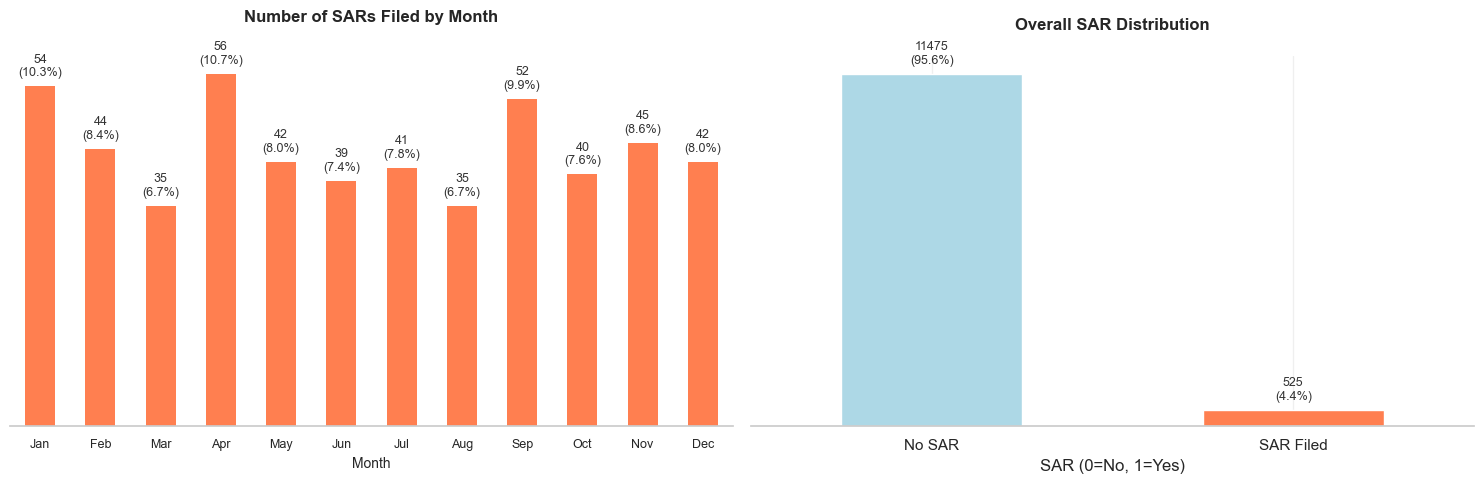

In [13]:
# Analyze SAR distribution
print("=" * 80)
print("SAR DISTRIBUTION ANALYSIS")
print("=" * 80)

# Overall SAR statistics
total_records = len(df_label)
total_sars = df_label['SAR'].sum()
sar_rate = (total_sars / total_records) * 100

print(f"Total Customer-Month Records: {total_records:,}")
print(f"Total SARs Filed: {total_sars:,}")
print(f"SAR Rate: {sar_rate:.2f}%")
print(f"Class Imbalance Ratio: {(total_records - total_sars) / total_sars:.1f}:1")

# Customer-level SAR analysis
customers_with_sar = df_label[df_label['SAR'] == 1]['Customer_ID'].nunique()
total_customers = df_label['Customer_ID'].nunique()
print(f"\nCustomers with at least one SAR: {customers_with_sar} / {total_customers} ({customers_with_sar/total_customers*100:.1f}%)")

# SAR distribution by month
sar_by_month = df_label.groupby('Month')['SAR'].agg(['sum', 'count', 'mean'])
sar_by_month['sar_rate'] = sar_by_month['mean'] * 100
print("\n" + "=" * 80)
print("SARs by Month")
print("=" * 80)
print(sar_by_month)

# Visualize SAR distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# SAR by month
# Define month order
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

bars = sar_by_month['sum'].plot(kind='bar', ax=axes[0], color='coral', edgecolor='none')

# Title & labels
axes[0].set_title('Number of SARs Filed by Month\n', fontsize=12, fontweight='bold', pad=12)
axes[0].set_xlabel('Month', fontsize=10)
axes[0].set_ylabel('')  # Remove y-label text

# Remove y-axis entirely (spine + ticks + labels)
axes[0].get_yaxis().set_visible(False)
axes[0].spines['left'].set_visible(False)
axes[0].spines['right'].set_visible(False)

# Keep only bottom spine for minimalism
axes[0].spines['top'].set_visible(False)
axes[0].spines['bottom'].set_color('#cccccc')

# Grid: subtle horizontal only (since y-axis is gone, lighter grid helps)
axes[0].grid(axis='y', color='#e0e0e0', linestyle='-', linewidth=0.7, alpha=0.7)
axes[0].set_axisbelow(True)  # grid behind bars

# Add value + % labels on bars
total = sar_by_month['sum'].sum()
max_val = sar_by_month['sum'].max()
for i, (month, count) in enumerate(sar_by_month['sum'].items()):
    if total > 0:
        pct = 100 * count / total
        label = f'{int(count)}\n({pct:.1f}%)'
    else:
        label = f'{int(count)}\n(0.0%)'
    # Slightly above bar; offset scales with data range
    offset = max_val * 0.02 if max_val > 0 else 1
    axes[0].text(i, count + offset, label,
                 ha='center', va='bottom',
                 fontsize=9, fontweight='medium', color='#333333')

# Improve x-tick appearance
axes[0].set_xticklabels(month_order, rotation=0, fontsize=9)

# Class distribution

class_bars = df_label['SAR'].value_counts().plot(kind='bar', ax=axes[1], color=['lightblue', 'coral'])
axes[1].set_title('Overall SAR Distribution\n', fontsize=12, fontweight='bold')
axes[1].set_xlabel('SAR (0=No, 1=Yes)')
axes[1].set_ylabel('') # Remove y-label text
axes[1].set_xticklabels(['No SAR', 'SAR Filed'], rotation=0)
axes[1].grid(alpha=0.3)

# Remove y-axis entirely (spine + ticks + labels)
axes[1].get_yaxis().set_visible(False)
axes[1].spines['left'].set_visible(False)
axes[1].spines['right'].set_visible(False)

# Keep only bottom spine for minimalism
axes[1].spines['top'].set_visible(False)
axes[1].spines['bottom'].set_color('#cccccc')

# Grid: subtle horizontal only (since y-axis is gone, lighter grid helps)
axes[1].grid(axis='y', color='#e0e0e0', linestyle='-', linewidth=0.7, alpha=0.7)
axes[1].set_axisbelow(True)  # grid behind bars

# Add value + % labels on bars
# Get value counts
counts = df_label['SAR'].value_counts()
total = counts.sum()
max_val=counts.max()
for i, (class_val, count) in enumerate(counts.items()):
    if total > 0:
        pct = 100 * count / total
        label = f'{int(count)}\n({pct:.1f}%)'
    else:
        label = f'{int(count)}\n(0.0%)'
    # Slightly above bar; offset scales with data range
    offset = max_val * 0.02 if max_val > 0 else 1
    axes[1].text(i, count + offset, label,
                 ha='center', va='bottom',
                 fontsize=9, fontweight='medium', color='#333333')


plt.tight_layout()
plt.show()

### Statistical Significance Test: SAR Distribution Across Months

**Research Question:** Are the differences in SAR counts across months statistically significant, or could they be due to random chance?

For example, we observe:
- January: 54 SARs
- April: 56 SARs
- Other months: varying counts

**Appropriate Test:** We'll use the **Chi-Square Goodness-of-Fit Test** to determine if the observed distribution of SARs across months differs significantly from what we would expect if SARs were uniformly distributed (i.e., equal probability for each month).

**Hypotheses:**
- **H₀ (Null Hypothesis):** SARs are uniformly distributed across all months (no seasonal pattern)
- **H₁ (Alternative Hypothesis):** SARs are NOT uniformly distributed across months (there IS a seasonal pattern)

**Interpretation:**
- If p-value < 0.05: We reject H₀ → There IS a statistically significant difference across months
- If p-value ≥ 0.05: We fail to reject H₀ → Differences could be due to random chance

In [ ]:
# Statistical Significance Test: Chi-Square Goodness-of-Fit Test
from scipy import stats

print("=" * 80)
print("CHI-SQUARE GOODNESS-OF-FIT TEST: SAR DISTRIBUTION ACROSS MONTHS")
print("=" * 80)

# Observed SAR counts by month
observed_counts = sar_by_month['sum'].values
months = sar_by_month.index.tolist()

print("\nObserved SAR counts by month:")
for month, count in zip(months, observed_counts):
    print(f"  {month}: {int(count)}")

# Total SARs
total_sars = observed_counts.sum()
num_months = len(observed_counts)

# Expected counts if uniformly distributed (equal SARs per month)
expected_counts = np.array([total_sars / num_months] * num_months)

print(f"\nTotal SARs: {int(total_sars)}")
print(f"Number of months: {num_months}")
print(f"Expected count per month (if uniform): {total_sars / num_months:.2f}")

# Perform Chi-Square test
chi2_statistic, p_value = stats.chisquare(f_obs=observed_counts, f_exp=expected_counts)

print("\n" + "=" * 80)
print("TEST RESULTS")
print("=" * 80)
print(f"Chi-Square Statistic: {chi2_statistic:.4f}")
print(f"P-value: {p_value:.6f}")
print(f"Degrees of Freedom: {num_months - 1}")

# Interpretation
alpha = 0.05
print("\n" + "=" * 80)
print("INTERPRETATION")
print("=" * 80)
print(f"Significance Level (α): {alpha}")

if p_value < alpha:
    print(f"\n✓ Result: STATISTICALLY SIGNIFICANT (p = {p_value:.6f} < {alpha})")
    print("\nConclusion:")
    print("  We REJECT the null hypothesis.")
    print("  The distribution of SARs across months is NOT uniform.")
    print("  There IS a statistically significant seasonal pattern in SAR filings.")
    print("\n  Implication: Some months have significantly more/fewer SARs than expected.")
    print("  This could indicate seasonal criminal activity patterns or operational factors.")
else:
    print(f"\n✗ Result: NOT STATISTICALLY SIGNIFICANT (p = {p_value:.6f} ≥ {alpha})")
    print("\nConclusion:")
    print("  We FAIL TO REJECT the null hypothesis.")
    print("  The distribution of SARs across months could be due to random variation.")
    print("  There is NO strong evidence of a seasonal pattern in SAR filings.")

# Additional analysis: Identify months with highest/lowest SARs
print("\n" + "=" * 80)
print("DESCRIPTIVE STATISTICS BY MONTH")
print("=" * 80)

sar_stats = pd.DataFrame({
    'Month': months,
    'Observed': observed_counts.astype(int),
    'Expected': expected_counts,
    'Difference': (observed_counts - expected_counts),
    'Pct_Difference': ((observed_counts - expected_counts) / expected_counts * 100)
}).sort_values('Observed', ascending=False)

print("\nMonths ranked by SAR count:")
print(sar_stats.to_string(index=False))

print("\n" + "=" * 80)
print("KEY OBSERVATIONS:")
print("=" * 80)
highest_month = sar_stats.iloc[0]
lowest_month = sar_stats.iloc[-1]
print(f"• Highest SAR count: {highest_month['Month']} with {highest_month['Observed']} SARs "
      f"({highest_month['Pct_Difference']:.1f}% above expected)")
print(f"• Lowest SAR count: {lowest_month['Month']} with {lowest_month['Observed']} SARs "
      f"({lowest_month['Pct_Difference']:.1f}% below expected)")
print(f"• Range: {int(highest_month['Observed'] - lowest_month['Observed'])} SARs difference "
      f"between highest and lowest months")

In [ ]:
# Visualize Observed vs Expected SAR Distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Plot 1: Observed vs Expected Counts
x = np.arange(len(months))
width = 0.35

bars1 = axes[0].bar(x - width/2, observed_counts, width, label='Observed', color='coral', alpha=0.8)
bars2 = axes[0].bar(x + width/2, expected_counts, width, label='Expected (Uniform)', color='lightblue', alpha=0.8)

axes[0].set_xlabel('Month', fontsize=11)
axes[0].set_ylabel('Number of SARs', fontsize=11)
axes[0].set_title('Observed vs Expected SAR Distribution Across Months\n(Chi-Square Test)', 
                  fontsize=12, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(months, rotation=45, ha='right')
axes[0].legend(fontsize=10)
axes[0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height)}',
                    ha='center', va='bottom', fontsize=8)

# Add p-value annotation
textstr = f'Chi² = {chi2_statistic:.2f}\np-value = {p_value:.4f}\n'
if p_value < 0.05:
    textstr += 'Significant ✓'
    box_color = 'lightgreen'
else:
    textstr += 'Not Significant'
    box_color = 'lightyellow'
    
props = dict(boxstyle='round', facecolor=box_color, alpha=0.8)
axes[0].text(0.98, 0.97, textstr, transform=axes[0].transAxes, fontsize=10,
            verticalalignment='top', horizontalalignment='right', bbox=props)

# Plot 2: Deviation from Expected
differences = observed_counts - expected_counts
colors = ['green' if d > 0 else 'red' for d in differences]

axes[1].bar(x, differences, color=colors, alpha=0.7)
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
axes[1].set_xlabel('Month', fontsize=11)
axes[1].set_ylabel('Difference from Expected', fontsize=11)
axes[1].set_title('Deviation from Expected SAR Count\n(Positive = Above Expected, Negative = Below Expected)', 
                  fontsize=12, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(months, rotation=45, ha='right')
axes[1].grid(axis='y', alpha=0.3)

# Add value labels
for i, (diff, month) in enumerate(zip(differences, months)):
    axes[1].text(i, diff + (0.5 if diff > 0 else -0.5), f'{diff:+.1f}',
                ha='center', va='bottom' if diff > 0 else 'top', fontsize=8)

plt.tight_layout()
plt.show()

# Summary statement
print("\n" + "=" * 80)
print("VISUAL SUMMARY:")
print("=" * 80)
print("The left chart compares observed SAR counts (coral) with expected counts (blue)")
print("if SARs were uniformly distributed. The right chart shows the deviation of each")
print("month from the expected value (green = above expected, red = below expected).")

### Why This Statistical Test Matters for AML

**Business Impact:**

1. **Operational Planning:**
   - If the test shows **significant** differences: The bank needs to allocate more compliance resources during high-SAR months
   - If the test shows **no significance**: SAR workload is relatively stable year-round

2. **Pattern Recognition:**
   - Significant seasonal patterns could indicate:
     - Criminal activity trends (e.g., holiday-related fraud)
     - Business cycles affecting customer behavior
     - Regulatory reporting deadlines
     - Data quality or operational issues

3. **Model Development:**
   - If months matter statistically, we should consider adding "month" as a feature in our ML models
   - Time-based features could improve prediction accuracy

4. **Statistical Validity:**
   - With only 2 SARs difference between Jan (54) and Apr (56), we need statistical testing to determine if this is:
     - **Meaningful variation** requiring investigation, or
     - **Random noise** that's expected in any dataset

**Note on Sample Size:**
- With 525 total SARs across 12 months, we have sufficient data for chi-square test validity
- Chi-square test requires expected frequency ≥ 5 per category (we exceed this threshold)

In [14]:
# Customer-level SAR analysis
customers_with_sar = df_label[df_label['SAR'] == 1]['Customer_ID'].nunique()
total_customers = df_label['Customer_ID'].nunique()
print(f"\nCustomers with at least one SAR: {customers_with_sar} / {total_customers} ({customers_with_sar/total_customers*100:.1f}%)")



Customers with at least one SAR: 308 / 1000 (30.8%)


## Feature Engineering from Transaction Data

In [15]:
df_transactions.head()

,Customer_ID,Customer_ID_Counterparty,Transaction_Value,Transaction_Type,Month
0,143,NaN,-221,Wire,Jan
1,758,NaN,13,Wire,Jan
2,485,NaN,25,Wire,Jan
3,238,NaN,-456,Wire,Jan
4,858,NaN,-4,Wire,Jan


In [ ]:
# Engineer features from transaction data
print("Creating transaction features per customer per month...")

# Filter out salary transactions before all feature engineering
df_transactions_no_salary = df_transactions[df_transactions['Transaction_Type'] != 'Salary'].copy()

# Create aggregated features
transaction_features = df_transactions_no_salary.groupby(['Customer_ID', 'Month']).agg({
    'Transaction_Value': [
        'count',  # Number of transactions
        'sum',    # Total transaction value (net)
        'mean',   # Average transaction value
        'std',    # Standard deviation
        'min',    # Minimum transaction
        'max'     # Maximum transaction
    ]
}).reset_index()

# Flatten column names
transaction_features.columns = ['Customer_ID', 'Month', 'txn_count', 'txn_sum', 
                                 'txn_mean', 'txn_std', 'txn_min', 'txn_max']

# Additional features
# Turnover (sum of absolute values - excluding salary assumption)
df_transactions_no_salary['abs_value'] = df_transactions_no_salary['Transaction_Value'].abs()
turnover_features = df_transactions_no_salary.groupby(['Customer_ID', 'Month'])['abs_value'].sum().reset_index()
turnover_features.columns = ['Customer_ID', 'Month', 'turnover']

# Count incoming vs outgoing transactions
df_transactions_no_salary['incoming'] = (df_transactions_no_salary['Transaction_Value'] > 0).astype(int)
df_transactions_no_salary['outgoing'] = (df_transactions_no_salary['Transaction_Value'] < 0).astype(int)

flow_features = df_transactions_no_salary.groupby(['Customer_ID', 'Month']).agg({
    'incoming': 'sum',
    'outgoing': 'sum',
    # 'Transaction_Value': lambda x: (x > 0).sum()  # incoming count
}).reset_index()
flow_features.columns = ['Customer_ID', 'Month', 'incoming_count', 'outgoing_count']

# Calculate incoming and outgoing amounts
incoming_amt = df_transactions_no_salary[df_transactions_no_salary['Transaction_Value'] > 0].groupby(['Customer_ID', 'Month'])['Transaction_Value'].sum().reset_index()
incoming_amt.columns = ['Customer_ID', 'Month', 'incoming_amount']

outgoing_amt = df_transactions_no_salary[df_transactions_no_salary['Transaction_Value'] < 0].groupby(['Customer_ID', 'Month'])['Transaction_Value'].sum().reset_index()
outgoing_amt.columns = ['Customer_ID', 'Month', 'outgoing_amount']

# Internal transactions (transactions with counterparty that is also a customer)
internal_txn = df_transactions_no_salary[df_transactions_no_salary['Customer_ID_Counterparty'].notna()].groupby(['Customer_ID', 'Month']).size().reset_index()
internal_txn.columns = ['Customer_ID', 'Month', 'internal_txn_count']

# Merge all transaction features
features = transaction_features.merge(turnover_features, on=['Customer_ID', 'Month'], how='left')
features = features.merge(flow_features, on=['Customer_ID', 'Month'], how='left')
features = features.merge(incoming_amt, on=['Customer_ID', 'Month'], how='left')
features = features.merge(outgoing_amt, on=['Customer_ID', 'Month'], how='left')
features = features.merge(internal_txn, on=['Customer_ID', 'Month'], how='left')
features = features.merge(cash_txn, on=['Customer_ID', 'Month'], how='left')
features = features.merge(intl_txn, on=['Customer_ID', 'Month'], how='left')

# Fill NaN values
features['txn_std'] = features['txn_std'].fillna(0)
features['internal_txn_count'] = features['internal_txn_count'].fillna(0)
features['incoming_amount'] = features['incoming_amount'].fillna(0)
features['outgoing_amount'] = features['outgoing_amount'].fillna(0)
features['cash_txn_count'] = features['cash_txn_count'].fillna(0)
features['cash_txn_amount'] = features['cash_txn_amount'].fillna(0)
features['intl_txn_count'] = features['intl_txn_count'].fillna(0)
features['intl_txn_amount'] = features['intl_txn_amount'].fillna(0)

# Additional derived features
features['txn_range'] = features['txn_max'] - features['txn_min']
features['flow_ratio'] = features['incoming_amount'] / (features['outgoing_amount'].abs() + 1)
features['internal_txn_ratio'] = features['internal_txn_count'] / features['txn_count']

print(f"Transaction features created: {features.shape}")
print(f"Feature columns: {list(features.columns)}")
print("\nSample of transaction features:")
print(features.head(10))

Creating transaction features per customer per month...
Transaction features created: (12000, 17)
Feature columns: ['Customer_ID', 'Month', 'txn_count', 'txn_sum', 'txn_mean', 'txn_std', 'txn_min', 'txn_max', 'turnover', 'incoming_count', 'outgoing_count', 'incoming_amount', 'outgoing_amount', 'internal_txn_count', 'txn_range', 'flow_ratio', 'internal_txn_ratio']

Sample of transaction features:
   Customer_ID Month  txn_count  txn_sum    txn_mean      txn_std  txn_min  \
0            1   Apr          9    -4275 -475.000000   772.822263    -2082   
1            1   Aug         15     3344  222.933333  1145.023672    -1446   
2            1   Dec         16    -3261 -203.812500   297.794833     -708   
3            1   Feb          8    -4996 -624.500000   480.452465    -1367   
4            1   Jan         13    -2602 -200.153846   545.479735    -1680   
5            1   Jul          9    -5811 -645.666667   606.540807    -1669   
6            1   Jun          9    -3776 -419.555556   

In [ ]:
# ====================================================================================
# KYC BEHAVIORAL MISMATCH FEATURES
# Capture discrepancies between declared intentions (KYC) and actual behavior (transactions)
# ====================================================================================

# 1. Cash Transaction Behavior vs KYC Declaration
# Customers who said NO to cash deposits but made cash transactions
cash_txn = df_transactions_no_salary[df_transactions_no_salary['Transaction_Type'] == 'Cash'].groupby(['Customer_ID', 'Month']).agg({
    'Transaction_Value': ['count', lambda x: x.abs().sum()]  # count and total amount
}).reset_index()
cash_txn.columns = ['Customer_ID', 'Month', 'cash_txn_count', 'cash_txn_amount']

# 2. International Transaction Behavior vs KYC Declaration
# Customers who said NO to international payments but made international transactions
intl_txn = df_transactions_no_salary[df_transactions_no_salary['Transaction_Type'] == 'International'].groupby(['Customer_ID', 'Month']).agg({
    'Transaction_Value': ['count', lambda x: x.abs().sum()]  # count and total amount
}).reset_index()
intl_txn.columns = ['Customer_ID', 'Month', 'intl_txn_count', 'intl_txn_amount']

print("Behavioral mismatch features created:")
print(f"- Cash transactions: {cash_txn.shape}")
print(f"- International transactions: {intl_txn.shape}")

### Behavioral Mismatch Features

**Red Flag Detection: KYC Declaration vs. Actual Behavior**

A key AML indicator is when customers' actual transaction behavior doesn't match what they declared during KYC onboarding. We've engineered the following features:

#### 1. **Cash Transaction Mismatches**
- `cash_txn_count`: Number of cash transactions per customer per month
- `cash_txn_amount`: Total cash transaction amount (absolute value)
- `cash_mismatch`: Binary flag (1 if customer said NO to cash deposits but made cash transactions)
- `cash_mismatch_count`: Number of cash transactions for customers with mismatches
- `cash_mismatch_amount`: Total cash amount for customers with mismatches

#### 2. **International Payment Mismatches**
- `intl_txn_count`: Number of international transactions per customer per month
- `intl_txn_amount`: Total international transaction amount (absolute value)
- `intl_mismatch`: Binary flag (1 if customer said NO to international payments but made them)
- `intl_mismatch_count`: Number of international transactions for customers with mismatches
- `intl_mismatch_amount`: Total international amount for customers with mismatches

**Why This Matters for AML:**
- Criminals often lie about their intended account usage to avoid scrutiny
- Behavior that contradicts stated intentions is a strong red flag
- These features may have high predictive power for SAR detection

In [44]:
# Merge with KYC and Label data
# First, merge features with labels
df_complete = features.merge(df_label, on=['Customer_ID', 'Month'], how='left')

# Then merge with KYC data
df_complete = df_complete.merge(df_kyc, on='Customer_ID', how='left')

# Convert boolean columns to int
bool_columns = ['High_Risk_Country', 'Vulnerable_Area', 'Intention_International_Payments', 'Intention_Cash_Deposits']
for col in bool_columns:
    df_complete[col] = df_complete[col].astype(int)

# Handle Sex encoding
df_complete['Sex'] = df_complete['Sex'].map({'Male': 1, 'Female': 0})

print(f"Complete dataset shape: {df_complete.shape}")
print(f"\nColumns: {list(df_complete.columns)}")
print(f"\nMissing values:")
print(df_complete.isnull().sum())
print("\nFirst few rows:")
print(df_complete.head())

Complete dataset shape: (12000, 24)

Columns: ['Customer_ID', 'Month', 'txn_count', 'txn_sum', 'txn_mean', 'txn_std', 'txn_min', 'txn_max', 'turnover', 'incoming_count', 'outgoing_count', 'incoming_amount', 'outgoing_amount', 'internal_txn_count', 'txn_range', 'flow_ratio', 'internal_txn_ratio', 'SAR', 'Age', 'Sex', 'High_Risk_Country', 'Vulnerable_Area', 'Intention_International_Payments', 'Intention_Cash_Deposits']

Missing values:
Customer_ID                         0
Month                               0
txn_count                           0
txn_sum                             0
txn_mean                            0
txn_std                             0
txn_min                             0
txn_max                             0
turnover                            0
incoming_count                      0
outgoing_count                      0
incoming_amount                     0
outgoing_amount                     0
internal_txn_count                  0
txn_range                     

In [ ]:
# ====================================================================================
# CREATE BEHAVIORAL MISMATCH INDICATORS
# Red Flag Features: Behavior not matching declared intentions
# ====================================================================================

# 1. Cash Mismatch: Customer said NO to cash deposits but made cash transactions
# If Intention_Cash_Deposits == 0 (False) AND cash_txn_count > 0, this is a red flag
df_complete['cash_mismatch'] = ((df_complete['Intention_Cash_Deposits'] == 0) & 
                                 (df_complete['cash_txn_count'] > 0)).astype(int)

# 2. International Mismatch: Customer said NO to international payments but made them
# If Intention_International_Payments == 0 (False) AND intl_txn_count > 0, this is a red flag
df_complete['intl_mismatch'] = ((df_complete['Intention_International_Payments'] == 0) & 
                                 (df_complete['intl_txn_count'] > 0)).astype(int)

# 3. For customers with mismatches, capture the extent of the mismatch
# Only count/amount if there's a mismatch
df_complete['cash_mismatch_count'] = df_complete['cash_mismatch'] * df_complete['cash_txn_count']
df_complete['cash_mismatch_amount'] = df_complete['cash_mismatch'] * df_complete['cash_txn_amount']
df_complete['intl_mismatch_count'] = df_complete['intl_mismatch'] * df_complete['intl_txn_count']
df_complete['intl_mismatch_amount'] = df_complete['intl_mismatch'] * df_complete['intl_txn_amount']

# Summary statistics
print("=" * 80)
print("BEHAVIORAL MISMATCH ANALYSIS")
print("=" * 80)
print(f"\nCash Transaction Mismatches:")
print(f"  Total customer-months with mismatch: {df_complete['cash_mismatch'].sum():,}")
print(f"  % of all records: {df_complete['cash_mismatch'].mean()*100:.2f}%")
print(f"  Avg transactions when mismatch: {df_complete[df_complete['cash_mismatch']==1]['cash_txn_count'].mean():.2f}")
print(f"  Avg amount when mismatch: €{df_complete[df_complete['cash_mismatch']==1]['cash_txn_amount'].mean():,.2f}")

print(f"\nInternational Payment Mismatches:")
print(f"  Total customer-months with mismatch: {df_complete['intl_mismatch'].sum():,}")
print(f"  % of all records: {df_complete['intl_mismatch'].mean()*100:.2f}%")
print(f"  Avg transactions when mismatch: {df_complete[df_complete['intl_mismatch']==1]['intl_txn_count'].mean():.2f}")
print(f"  Avg amount when mismatch: €{df_complete[df_complete['intl_mismatch']==1]['intl_txn_amount'].mean():,.2f}")

# Correlation with SAR
print(f"\n{'Feature':<30} {'Correlation with SAR':<20}")
print("-" * 50)
print(f"{'cash_mismatch':<30} {df_complete[['cash_mismatch', 'SAR']].corr().iloc[0,1]:.4f}")
print(f"{'intl_mismatch':<30} {df_complete[['intl_mismatch', 'SAR']].corr().iloc[0,1]:.4f}")
print(f"{'cash_mismatch_count':<30} {df_complete[['cash_mismatch_count', 'SAR']].corr().iloc[0,1]:.4f}")
print(f"{'intl_mismatch_count':<30} {df_complete[['intl_mismatch_count', 'SAR']].corr().iloc[0,1]:.4f}")

# SAR rate by mismatch
print(f"\nSAR Rates by Mismatch Status:")
print(f"  Cash mismatch - No: {df_complete[df_complete['cash_mismatch']==0]['SAR'].mean()*100:.2f}%")
print(f"  Cash mismatch - Yes: {df_complete[df_complete['cash_mismatch']==1]['SAR'].mean()*100:.2f}%")
print(f"  Intl mismatch - No: {df_complete[df_complete['intl_mismatch']==0]['SAR'].mean()*100:.2f}%")
print(f"  Intl mismatch - Yes: {df_complete[df_complete['intl_mismatch']==1]['SAR'].mean()*100:.2f}%")

In [ ]:
# Visualize Behavioral Mismatch Features
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Cash Mismatch by SAR Status
mismatch_sar = df_complete.groupby(['cash_mismatch', 'SAR']).size().unstack(fill_value=0)
mismatch_sar.plot(kind='bar', ax=axes[0, 0], color=['lightblue', 'coral'])
axes[0, 0].set_title('Cash Mismatch Distribution by SAR Status', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Cash Mismatch (0=No, 1=Yes)')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_xticklabels(['No Mismatch', 'Mismatch'], rotation=0)
axes[0, 0].legend(['No SAR', 'SAR Filed'], loc='upper right')
axes[0, 0].grid(alpha=0.3, axis='y')

# 2. International Mismatch by SAR Status
intl_mismatch_sar = df_complete.groupby(['intl_mismatch', 'SAR']).size().unstack(fill_value=0)
intl_mismatch_sar.plot(kind='bar', ax=axes[0, 1], color=['lightblue', 'coral'])
axes[0, 1].set_title('International Mismatch Distribution by SAR Status', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('International Mismatch (0=No, 1=Yes)')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_xticklabels(['No Mismatch', 'Mismatch'], rotation=0)
axes[0, 1].legend(['No SAR', 'SAR Filed'], loc='upper right')
axes[0, 1].grid(alpha=0.3, axis='y')

# 3. SAR Rate by Mismatch Status
sar_rates = pd.DataFrame({
    'Cash Mismatch': [
        df_complete[df_complete['cash_mismatch']==0]['SAR'].mean() * 100,
        df_complete[df_complete['cash_mismatch']==1]['SAR'].mean() * 100
    ],
    'Intl Mismatch': [
        df_complete[df_complete['intl_mismatch']==0]['SAR'].mean() * 100,
        df_complete[df_complete['intl_mismatch']==1]['SAR'].mean() * 100
    ]
}, index=['No Mismatch', 'Mismatch'])

sar_rates.plot(kind='bar', ax=axes[1, 0], color=['steelblue', 'darkorange'], width=0.7)
axes[1, 0].set_title('SAR Rate (%) by Mismatch Type', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Mismatch Status')
axes[1, 0].set_ylabel('SAR Rate (%)')
axes[1, 0].set_xticklabels(['No Mismatch', 'Mismatch'], rotation=0)
axes[1, 0].legend(loc='upper left')
axes[1, 0].grid(alpha=0.3, axis='y')

# Add value labels on bars
for container in axes[1, 0].containers:
    axes[1, 0].bar_label(container, fmt='%.2f%%', padding=3)

# 4. Box plot: Mismatch transaction amounts by SAR
# Combine both types of mismatches
df_viz = df_complete[df_complete['cash_mismatch'] == 1][['cash_txn_amount', 'SAR']].copy()
df_viz['amount'] = df_viz['cash_txn_amount']
df_viz['type'] = 'Cash'
df_viz2 = df_complete[df_complete['intl_mismatch'] == 1][['intl_txn_amount', 'SAR']].copy()
df_viz2['amount'] = df_viz2['intl_txn_amount']
df_viz2['type'] = 'International'
df_combined = pd.concat([df_viz[['amount', 'SAR', 'type']], df_viz2[['amount', 'SAR', 'type']]])

if len(df_combined) > 0:
    df_combined.boxplot(column='amount', by=['type', 'SAR'], ax=axes[1, 1])
    axes[1, 1].set_title('Transaction Amount Distribution (Mismatch Cases Only)', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('Type and SAR Status')
    axes[1, 1].set_ylabel('Transaction Amount (€)')
    axes[1, 1].set_xticklabels(['Cash\nNo SAR', 'Cash\nSAR', 'Intl\nNo SAR', 'Intl\nSAR'], rotation=0, fontsize=9)
    plt.suptitle('')
else:
    axes[1, 1].text(0.5, 0.5, 'No Mismatch Cases', ha='center', va='center', fontsize=14)
    axes[1, 1].set_title('Transaction Amount Distribution (Mismatch Cases Only)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

## 5. Exploratory Data Analysis (EDA)

### Correlation analysis

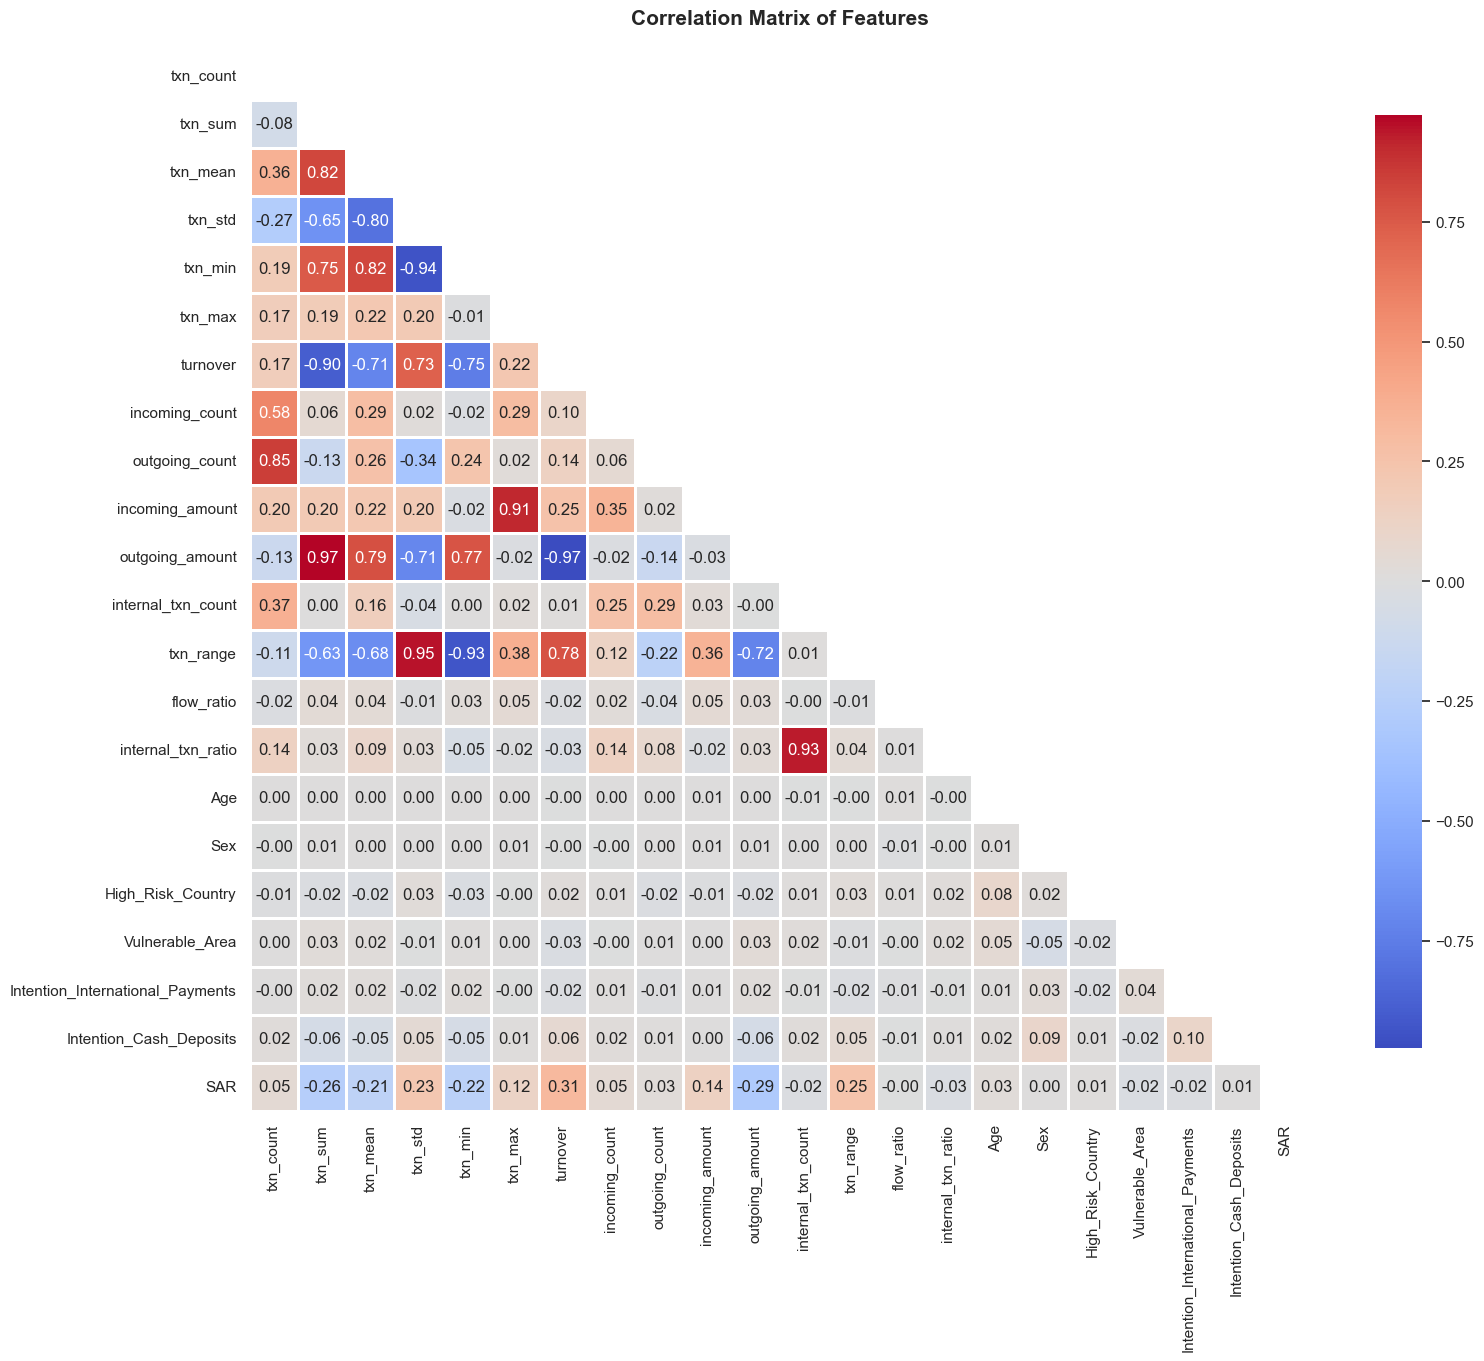


TOP FEATURES CORRELATED WITH SAR
SAR                   1.000000
turnover              0.314182
outgoing_amount       0.292332
txn_sum               0.255062
txn_range             0.248401
txn_std               0.226320
txn_min               0.222717
txn_mean              0.207508
incoming_amount       0.139000
txn_max               0.115188
incoming_count        0.046370
txn_count             0.046040
Age                   0.029446
internal_txn_ratio    0.029128
outgoing_count        0.026520
Name: SAR, dtype: float64


In [ ]:

# Select numeric features for correlation (including new behavioral mismatch features)
numeric_features = ['txn_count', 'txn_sum', 'txn_mean', 'txn_std', 'txn_min', 'txn_max', 'turnover', 
                    'incoming_count', 'outgoing_count', 'incoming_amount', 'outgoing_amount', 
                    'internal_txn_count', 'txn_range', 'flow_ratio', 'internal_txn_ratio',
                    'cash_txn_count', 'cash_txn_amount', 'intl_txn_count', 'intl_txn_amount',
                    'cash_mismatch', 'cash_mismatch_count', 'cash_mismatch_amount',
                    'intl_mismatch', 'intl_mismatch_count', 'intl_mismatch_amount',
                    'Age', 'Sex', 'High_Risk_Country', 'Vulnerable_Area', 
                    'Intention_International_Payments', 'Intention_Cash_Deposits', 'SAR']

# numeric_features = ['turnover', 'txn_count', 'txn_mean', 'txn_std', 'txn_min', 'txn_max',
#                     'incoming_count', 'outgoing_count', 'incoming_amount', 'outgoing_amount',
#                     'internal_txn_count', 'txn_range', 'flow_ratio', 'internal_txn_ratio',
#                     'Age', 'Sex', 'High_Risk_Country', 'Vulnerable_Area',
#                     'Intention_International_Payments', 'Intention_Cash_Deposits', 'SAR']

# Calculate correlation matrix
corr_matrix = df_complete[numeric_features].corr()

# Plot correlation heatmap
plt.figure(figsize=(16, 14))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix of Features', fontsize=15, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Top correlations with SAR
sar_corr = corr_matrix['SAR'].abs().sort_values(ascending=False)
print("\n" + "=" * 80)
print("TOP FEATURES CORRELATED WITH SAR")
print("=" * 80)
print(sar_corr.head(15))

### Comprehensive Statistical Testing for Feature Selection

**Objective:** Determine which features have statistically significant relationships with SAR (the target variable) to inform feature selection for our ML models.

**Approach:** Different feature types require different statistical tests:

1. **Continuous/Interval Features** (e.g., turnover, transaction counts, amounts)
   - Test: **Independent Samples T-Test** or **Mann-Whitney U Test** (if non-normal)
   - Compares mean values between SAR=0 and SAR=1 groups
   - H₀: No difference in means between groups

2. **Binary Features** (e.g., cash_mismatch, High_Risk_Country)
   - Test: **Chi-Square Test of Independence**
   - Tests association between two categorical variables
   - H₀: No association between feature and SAR

3. **Effect Size Metrics:**
   - **Cohen's d**: For continuous features (small: 0.2, medium: 0.5, large: 0.8)
   - **Cramér's V**: For categorical features (small: 0.1, medium: 0.3, large: 0.5)

**Significance Threshold:** p < 0.05 (with Bonferroni correction for multiple testing)

In [ ]:
# Comprehensive Statistical Testing for Feature Selection
from scipy import stats
from scipy.stats import mannwhitneyu, shapiro
import warnings
warnings.filterwarnings('ignore')

print("=" * 100)
print("COMPREHENSIVE STATISTICAL TESTING FOR FEATURE SELECTION")
print("=" * 100)

# Get all potential features (exclude identifiers and target)
exclude_cols = ['Customer_ID', 'Month', 'SAR']
all_features = [col for col in df_complete.columns if col not in exclude_cols]

print(f"\nTotal features to test: {len(all_features)}")
print(f"Target variable: SAR (Binary: 0=No SAR, 1=SAR Filed)")

# Separate groups
sar_group = df_complete[df_complete['SAR'] == 1]
no_sar_group = df_complete[df_complete['SAR'] == 0]

print(f"\nSample sizes:")
print(f"  SAR = 1: {len(sar_group):,} records")
print(f"  SAR = 0: {len(no_sar_group):,} records")

# ==============================================================================
# STEP 1: Categorize features by type
# ==============================================================================
print("\n" + "=" * 100)
print("STEP 1: CATEGORIZING FEATURES BY DATA TYPE")
print("=" * 100)

continuous_features = []
binary_features = []
categorical_features = []

for feature in all_features:
    n_unique = df_complete[feature].nunique()
    
    if n_unique == 2:
        binary_features.append(feature)
    elif n_unique <= 10 and df_complete[feature].dtype in ['object', 'category']:
        categorical_features.append(feature)
    else:
        # Treat as continuous if more than 10 unique values or numeric
        continuous_features.append(feature)

print(f"\n✓ Continuous/Interval Features: {len(continuous_features)}")
print(f"  {continuous_features[:10]}..." if len(continuous_features) > 10 else f"  {continuous_features}")

print(f"\n✓ Binary Features: {len(binary_features)}")
print(f"  {binary_features[:10]}..." if len(binary_features) > 10 else f"  {binary_features}")

print(f"\n✓ Categorical Features: {len(categorical_features)}")
print(f"  {categorical_features[:10]}..." if len(categorical_features) > 10 else f"  {categorical_features}")

In [ ]:
# ==============================================================================
# STEP 2: Test Continuous Features (Independent Samples T-Test / Mann-Whitney U)
# ==============================================================================
print("\n" + "=" * 100)
print("STEP 2: TESTING CONTINUOUS/INTERVAL FEATURES")
print("=" * 100)

continuous_results = []

for feature in continuous_features:
    # Get data for both groups (drop NaN)
    sar_data = sar_group[feature].dropna()
    no_sar_data = no_sar_group[feature].dropna()
    
    if len(sar_data) < 3 or len(no_sar_data) < 3:
        continue  # Skip if insufficient data
    
    # Calculate descriptive statistics
    mean_sar = sar_data.mean()
    mean_no_sar = no_sar_data.mean()
    std_sar = sar_data.std()
    std_no_sar = no_sar_data.std()
    
    # Test for normality (using Shapiro-Wilk on a sample if data is large)
    sample_size = min(5000, len(sar_data), len(no_sar_data))
    if len(sar_data) > sample_size:
        sar_sample = sar_data.sample(n=sample_size, random_state=42)
    else:
        sar_sample = sar_data
        
    if len(no_sar_data) > sample_size:
        no_sar_sample = no_sar_data.sample(n=sample_size, random_state=42)
    else:
        no_sar_sample = no_sar_data
    
    # Check normality
    try:
        _, p_norm_sar = shapiro(sar_sample)
        _, p_norm_no_sar = shapiro(no_sar_sample)
        is_normal = (p_norm_sar > 0.05) and (p_norm_no_sar > 0.05)
    except:
        is_normal = False
    
    # Perform appropriate test
    if is_normal:
        # T-test for normally distributed data
        t_stat, p_value = stats.ttest_ind(sar_data, no_sar_data)
        test_used = "T-Test"
    else:
        # Mann-Whitney U test for non-normal data
        u_stat, p_value = mannwhitneyu(sar_data, no_sar_data, alternative='two-sided')
        test_used = "Mann-Whitney U"
    
    # Calculate Cohen's d (effect size)
    pooled_std = np.sqrt(((len(sar_data)-1)*std_sar**2 + (len(no_sar_data)-1)*std_no_sar**2) / 
                         (len(sar_data) + len(no_sar_data) - 2))
    cohens_d = (mean_sar - mean_no_sar) / pooled_std if pooled_std > 0 else 0
    
    # Interpret effect size
    if abs(cohens_d) < 0.2:
        effect_size = "Negligible"
    elif abs(cohens_d) < 0.5:
        effect_size = "Small"
    elif abs(cohens_d) < 0.8:
        effect_size = "Medium"
    else:
        effect_size = "Large"
    
    continuous_results.append({
        'Feature': feature,
        'Test': test_used,
        'Mean_SAR': mean_sar,
        'Mean_No_SAR': mean_no_sar,
        'Std_SAR': std_sar,
        'Std_No_SAR': std_no_sar,
        'P_Value': p_value,
        'Cohens_d': cohens_d,
        'Effect_Size': effect_size,
        'Significant': p_value < 0.05
    })

# Create DataFrame and sort by p-value
df_continuous = pd.DataFrame(continuous_results).sort_values('P_Value')

print(f"\n✓ Tested {len(df_continuous)} continuous features")
print(f"✓ Significant features (p < 0.05): {df_continuous['Significant'].sum()}")
print(f"\nTop 20 most significant continuous features:")
print(df_continuous.head(20).to_string(index=False))

In [ ]:
# ==============================================================================
# STEP 3: Test Binary/Categorical Features (Chi-Square Test of Independence)
# ==============================================================================
print("\n" + "=" * 100)
print("STEP 3: TESTING BINARY AND CATEGORICAL FEATURES")
print("=" * 100)

categorical_results = []

for feature in binary_features + categorical_features:
    # Create contingency table
    contingency_table = pd.crosstab(df_complete[feature], df_complete['SAR'])
    
    # Skip if any expected frequency is too low
    if contingency_table.size == 0 or contingency_table.min().min() < 1:
        continue
    
    # Perform Chi-Square test
    try:
        chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)
        
        # Calculate Cramér's V (effect size for categorical variables)
        n = contingency_table.sum().sum()
        min_dim = min(contingency_table.shape[0] - 1, contingency_table.shape[1] - 1)
        cramers_v = np.sqrt(chi2 / (n * min_dim)) if min_dim > 0 else 0
        
        # Interpret effect size
        if cramers_v < 0.1:
            effect_size = "Negligible"
        elif cramers_v < 0.3:
            effect_size = "Small"
        elif cramers_v < 0.5:
            effect_size = "Medium"
        else:
            effect_size = "Large"
        
        # Calculate SAR rates for each category
        sar_rates = df_complete.groupby(feature)['SAR'].agg(['sum', 'count', 'mean'])
        sar_rate_str = "; ".join([f"{idx}:{row['mean']*100:.1f}%" 
                                  for idx, row in sar_rates.iterrows()])
        
        categorical_results.append({
            'Feature': feature,
            'Type': 'Binary' if feature in binary_features else 'Categorical',
            'N_Categories': contingency_table.shape[0],
            'Chi2': chi2,
            'P_Value': p_value,
            'Cramers_V': cramers_v,
            'Effect_Size': effect_size,
            'SAR_Rate_by_Category': sar_rate_str,
            'Significant': p_value < 0.05
        })
    except Exception as e:
        continue

# Create DataFrame and sort by p-value
df_categorical = pd.DataFrame(categorical_results).sort_values('P_Value')

print(f"\n✓ Tested {len(df_categorical)} binary/categorical features")
print(f"✓ Significant features (p < 0.05): {df_categorical['Significant'].sum()}")
print(f"\nAll binary/categorical features sorted by significance:")
print(df_categorical.to_string(index=False))

In [ ]:
# ==============================================================================
# STEP 4: Summary and Recommendations with Bonferroni Correction
# ==============================================================================
print("\n" + "=" * 100)
print("STEP 4: SUMMARY AND FEATURE SELECTION RECOMMENDATIONS")
print("=" * 100)

# Apply Bonferroni correction for multiple testing
total_tests = len(df_continuous) + len(df_categorical)
bonferroni_alpha = 0.05 / total_tests

print(f"\nMultiple Testing Correction:")
print(f"  Total tests performed: {total_tests}")
print(f"  Original α: 0.05")
print(f"  Bonferroni-corrected α: {bonferroni_alpha:.6f}")

# Update significance with Bonferroni correction
df_continuous['Significant_Bonferroni'] = df_continuous['P_Value'] < bonferroni_alpha
df_categorical['Significant_Bonferroni'] = df_categorical['P_Value'] < bonferroni_alpha

# Count significant features
sig_continuous = df_continuous['Significant'].sum()
sig_continuous_bonf = df_continuous['Significant_Bonferroni'].sum()
sig_categorical = df_categorical['Significant'].sum()
sig_categorical_bonf = df_categorical['Significant_Bonferroni'].sum()

print(f"\n" + "=" * 100)
print("SIGNIFICANCE SUMMARY")
print("=" * 100)
print(f"\nContinuous Features:")
print(f"  Significant (p < 0.05): {sig_continuous}/{len(df_continuous)} ({sig_continuous/len(df_continuous)*100:.1f}%)")
print(f"  Significant (Bonferroni): {sig_continuous_bonf}/{len(df_continuous)} ({sig_continuous_bonf/len(df_continuous)*100:.1f}%)")

print(f"\nBinary/Categorical Features:")
print(f"  Significant (p < 0.05): {sig_categorical}/{len(df_categorical)} ({sig_categorical/len(df_categorical)*100:.1f}%)")
print(f"  Significant (Bonferroni): {sig_categorical_bonf}/{len(df_categorical)} ({sig_categorical_bonf/len(df_categorical)*100:.1f}%)")

# Combine all results
all_results = []

for _, row in df_continuous.iterrows():
    all_results.append({
        'Feature': row['Feature'],
        'Type': 'Continuous',
        'P_Value': row['P_Value'],
        'Effect_Size': row['Effect_Size'],
        'Effect_Metric': f"Cohen's d = {row['Cohens_d']:.3f}",
        'Significant_p05': row['Significant'],
        'Significant_Bonferroni': row['Significant_Bonferroni'],
        'Mean_Diff': row['Mean_SAR'] - row['Mean_No_SAR']
    })

for _, row in df_categorical.iterrows():
    all_results.append({
        'Feature': row['Feature'],
        'Type': row['Type'],
        'P_Value': row['P_Value'],
        'Effect_Size': row['Effect_Size'],
        'Effect_Metric': f"Cramér's V = {row['Cramers_V']:.3f}",
        'Significant_p05': row['Significant'],
        'Significant_Bonferroni': row['Significant_Bonferroni'],
        'Mean_Diff': np.nan
    })

df_all_results = pd.DataFrame(all_results).sort_values('P_Value')

print("\n" + "=" * 100)
print("TOP 30 MOST SIGNIFICANT FEATURES (All Types Combined)")
print("=" * 100)
print(df_all_results.head(30).to_string(index=False))

# Recommendations
print("\n" + "=" * 100)
print("FEATURE SELECTION RECOMMENDATIONS")
print("=" * 100)

highly_significant = df_all_results[df_all_results['Significant_Bonferroni'] == True]
medium_significant = df_all_results[(df_all_results['Significant_p05'] == True) & 
                                     (df_all_results['Significant_Bonferroni'] == False)]

print(f"\n✓ TIER 1 - HIGHLY RECOMMENDED ({len(highly_significant)} features):")
print("   Passed Bonferroni correction (most robust, unlikely to be false positives)")
if len(highly_significant) > 0:
    print("   Features:", ", ".join(highly_significant['Feature'].tolist()))

print(f"\n✓ TIER 2 - RECOMMENDED ({len(medium_significant)} features):")
print("   Significant at p<0.05 but not after Bonferroni (still valuable)")
if len(medium_significant) > 0:
    print("   Features:", ", ".join(medium_significant['Feature'].head(15).tolist()))
    if len(medium_significant) > 15:
        print(f"   ... and {len(medium_significant)-15} more")

# Features with large effect sizes
large_effect = df_all_results[df_all_results['Effect_Size'].isin(['Large', 'Medium'])]
print(f"\n✓ FEATURES WITH LARGE/MEDIUM EFFECT SIZES ({len(large_effect)} features):")
print("   These have practical significance beyond statistical significance")
if len(large_effect) > 0:
    print(large_effect[['Feature', 'Effect_Size', 'Effect_Metric', 'P_Value']].head(15).to_string(index=False))

In [ ]:
# ==============================================================================
# STEP 5: Visualizations
# ==============================================================================
print("\n" + "=" * 100)
print("STEP 5: CREATING VISUALIZATIONS")
print("=" * 100)

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Plot 1: P-value distribution (log scale)
top_n = 30
top_features = df_all_results.head(top_n)

axes[0, 0].barh(range(len(top_features)), -np.log10(top_features['P_Value']), 
                color=['green' if x else 'orange' for x in top_features['Significant_Bonferroni']])
axes[0, 0].axvline(x=-np.log10(0.05), color='blue', linestyle='--', linewidth=2, label='α = 0.05')
axes[0, 0].axvline(x=-np.log10(bonferroni_alpha), color='red', linestyle='--', linewidth=2, 
                   label=f'Bonferroni α = {bonferroni_alpha:.6f}')
axes[0, 0].set_yticks(range(len(top_features)))
axes[0, 0].set_yticklabels(top_features['Feature'], fontsize=8)
axes[0, 0].set_xlabel('-log10(P-Value)', fontsize=11)
axes[0, 0].set_title(f'Top {top_n} Features by Statistical Significance\n(Green=Bonferroni, Orange=p<0.05)', 
                     fontsize=12, fontweight='bold')
axes[0, 0].legend(fontsize=9)
axes[0, 0].grid(axis='x', alpha=0.3)
axes[0, 0].invert_yaxis()

# Plot 2: Effect Size Distribution
continuous_with_effect = df_continuous[df_continuous['Significant'] == True].sort_values('Cohens_d', 
                                                                                          key=abs, ascending=False).head(20)
if len(continuous_with_effect) > 0:
    colors = ['red' if x < 0 else 'green' for x in continuous_with_effect['Cohens_d']]
    axes[0, 1].barh(range(len(continuous_with_effect)), continuous_with_effect['Cohens_d'], color=colors, alpha=0.7)
    axes[0, 1].axvline(x=0, color='black', linestyle='-', linewidth=0.8)
    axes[0, 1].axvline(x=0.2, color='gray', linestyle=':', linewidth=1, alpha=0.5)
    axes[0, 1].axvline(x=-0.2, color='gray', linestyle=':', linewidth=1, alpha=0.5)
    axes[0, 1].axvline(x=0.5, color='gray', linestyle='--', linewidth=1, alpha=0.5)
    axes[0, 1].axvline(x=-0.5, color='gray', linestyle='--', linewidth=1, alpha=0.5)
    axes[0, 1].set_yticks(range(len(continuous_with_effect)))
    axes[0, 1].set_yticklabels(continuous_with_effect['Feature'], fontsize=8)
    axes[0, 1].set_xlabel("Cohen's d (Effect Size)", fontsize=11)
    axes[0, 1].set_title("Effect Size for Top 20 Continuous Features\n(Red=Lower in SAR, Green=Higher in SAR)", 
                         fontsize=12, fontweight='bold')
    axes[0, 1].grid(axis='x', alpha=0.3)
    axes[0, 1].invert_yaxis()
else:
    axes[0, 1].text(0.5, 0.5, 'No significant continuous features', ha='center', va='center')

# Plot 3: Feature Type Distribution
feature_type_counts = df_all_results.groupby(['Type', 'Significant_p05']).size().unstack(fill_value=0)
feature_type_counts.plot(kind='bar', stacked=True, ax=axes[1, 0], 
                        color=['lightcoral', 'lightgreen'], alpha=0.8)
axes[1, 0].set_title('Feature Significance by Type', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Feature Type', fontsize=11)
axes[1, 0].set_ylabel('Count', fontsize=11)
axes[1, 0].legend(['Not Significant', 'Significant (p<0.05)'], loc='upper right')
axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=45, ha='right')
axes[1, 0].grid(axis='y', alpha=0.3)

# Plot 4: Effect Size Categories
effect_size_counts = df_all_results[df_all_results['Significant_p05'] == True].groupby('Effect_Size').size()
effect_size_order = ['Negligible', 'Small', 'Medium', 'Large']
effect_size_counts = effect_size_counts.reindex(effect_size_order, fill_value=0)

colors_effect = ['lightgray', 'yellow', 'orange', 'red']
axes[1, 1].bar(range(len(effect_size_counts)), effect_size_counts.values, 
               color=colors_effect, alpha=0.8, edgecolor='black')
axes[1, 1].set_xticks(range(len(effect_size_counts)))
axes[1, 1].set_xticklabels(effect_size_counts.index, rotation=0)
axes[1, 1].set_xlabel('Effect Size Category', fontsize=11)
axes[1, 1].set_ylabel('Number of Significant Features', fontsize=11)
axes[1, 1].set_title('Distribution of Effect Sizes\n(Among Significant Features)', fontsize=12, fontweight='bold')
axes[1, 1].grid(axis='y', alpha=0.3)

# Add value labels
for i, v in enumerate(effect_size_counts.values):
    axes[1, 1].text(i, v + 0.5, str(v), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✓ Visualizations created successfully!")

In [ ]:
# ==============================================================================
# STEP 6: Export Results and Create Feature Lists for Modeling
# ==============================================================================
print("\n" + "=" * 100)
print("STEP 6: FEATURE SELECTION LISTS FOR MODELING")
print("=" * 100)

# Create recommended feature lists
features_tier1 = df_all_results[df_all_results['Significant_Bonferroni'] == True]['Feature'].tolist()
features_tier2 = df_all_results[(df_all_results['Significant_p05'] == True) & 
                                 (df_all_results['Significant_Bonferroni'] == False)]['Feature'].tolist()

print(f"\n{'='*50}")
print("TIER 1 FEATURES (Highly Recommended - Bonferroni Corrected)")
print(f"{'='*50}")
print(f"Total: {len(features_tier1)} features\n")
for i, feat in enumerate(features_tier1, 1):
    print(f"{i:2d}. {feat}")

print(f"\n{'='*50}")
print("TIER 2 FEATURES (Recommended - Significant at p<0.05)")
print(f"{'='*50}")
print(f"Total: {len(features_tier2)} features\n")
for i, feat in enumerate(features_tier2[:20], 1):
    print(f"{i:2d}. {feat}")
if len(features_tier2) > 20:
    print(f"... and {len(features_tier2)-20} more features")

# Create Python lists for easy copy-paste
print(f"\n{'='*50}")
print("COPY-PASTE READY FEATURE LISTS")
print(f"{'='*50}")

print("\n# TIER 1 - Highest confidence features (Bonferroni corrected)")
print(f"features_tier1 = {features_tier1}")

print("\n# TIER 2 - Good features (p < 0.05)")
print(f"features_tier2 = {features_tier2}")

print("\n# ALL SIGNIFICANT - Combined list")
print(f"features_all_significant = features_tier1 + features_tier2")
print(f"# Total: {len(features_tier1) + len(features_tier2)} features")

# Save to CSV for reference
try:
    df_all_results.to_csv('data/statistical_test_results.csv', index=False)
    df_continuous.to_csv('data/continuous_features_tests.csv', index=False)
    df_categorical.to_csv('data/categorical_features_tests.csv', index=False)
    print("\n✓ Results exported to CSV files in data/ directory")
except:
    print("\n⚠ Could not save CSV files (directory may not exist)")

print("\n" + "=" * 100)
print("STATISTICAL TESTING COMPLETE!")
print("=" * 100)
print("\nNext Steps:")
print("1. Use TIER 1 features for your primary model (most robust)")
print("2. Experiment with adding TIER 2 features to see if they improve performance")
print("3. Consider features with large effect sizes even if p-value is borderline")
print("4. Monitor for multicollinearity among selected features")

---

### 📊 Summary: Comprehensive Statistical Feature Selection Framework

**What We Did:**

1. **Automatic Feature Categorization**
   - Identified continuous, binary, and categorical features automatically
   - Based on number of unique values and data types

2. **Appropriate Statistical Tests Applied**
   - **Continuous Features**: Independent Samples T-Test (normal data) or Mann-Whitney U Test (non-normal)
   - **Binary/Categorical Features**: Chi-Square Test of Independence
   - Automatically selected the right test based on data distribution

3. **Effect Size Calculations**
   - **Cohen's d** for continuous features (measures magnitude of difference)
   - **Cramér's V** for categorical features (measures strength of association)
   - Categorized as: Negligible, Small, Medium, Large

4. **Multiple Testing Correction**
   - Applied **Bonferroni correction** to control false positive rate
   - Created two tiers of features based on significance thresholds

5. **Comprehensive Results**
   - P-values, effect sizes, and practical interpretations
   - Visual comparisons and rankings
   - Export-ready feature lists for modeling

**Key Outputs:**
- ✅ **TIER 1 Features**: Passed Bonferroni correction (highest confidence)
- ✅ **TIER 2 Features**: Significant at p<0.05 (still valuable)
- 📈 Effect size analysis (which features have practical significance)
- 📊 Four visualization plots showing different perspectives
- 💾 CSV exports for future reference

**How to Use Results:**
- Start modeling with TIER 1 features (most robust)
- Add TIER 2 features incrementally to test performance improvement
- Pay attention to features with large effect sizes
- Consider domain knowledge alongside statistical significance

---

### Statistical Significance

In [ ]:
# Analyze feature distributions by SAR status
print("=" * 80)
print("FEATURE STATISTICS BY SAR STATUS")
print("=" * 80)

# Key transaction features
key_features = ['turnover', 'txn_count', 'txn_mean', 'txn_min', 'txn_range', 'incoming_amount', 
                    'outgoing_amount', 'internal_txn_count', 'flow_ratio',
                    'cash_txn_count', 'cash_txn_amount', 'intl_txn_count', 'intl_txn_amount',
                    'cash_mismatch', 'cash_mismatch_count', 'intl_mismatch', 'intl_mismatch_count',
                    'Age', 'High_Risk_Country', 'Vulnerable_Area', 'Intention_International_Payments', 
                    'Intention_Cash_Deposits']

comparison = df_complete.groupby('SAR')[key_features].mean()
print("\nMean values by SAR status:")
print(comparison.round(2))

# Statistical significance
from scipy import stats
print("\n" + "=" * 80)
print("STATISTICAL TESTS (SAR vs No SAR)")
print("=" * 80)

for feature in key_features:
    sar_data = df_complete[df_complete['SAR'] == 1][feature]
    no_sar_data = df_complete[df_complete['SAR'] == 0][feature]
    
    # T-test
    t_stat, p_value = stats.ttest_ind(sar_data.dropna(), no_sar_data.dropna())
    significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "NS"
    
    print(f"{feature:<25} p-value: {p_value:.6f} {significance}")

print("\n*** p < 0.001, ** p < 0.01, * p < 0.05, NS = Not Significant")

FEATURE STATISTICS BY SAR STATUS

Mean values by SAR status:
     turnover  txn_count  txn_mean  txn_min  txn_range  incoming_amount  \
SAR                                                                       
0     6232.79      12.97   -467.93 -1792.78    1993.63           313.68   
1    11820.58      13.84   -824.07 -3190.10    3676.58           867.71   

     outgoing_amount  internal_txn_count  flow_ratio    Age  \
SAR                                                           
0           -5919.11                1.21        0.13  51.09   
1          -10952.88                1.10        0.12  53.97   

     High_Risk_Country  Vulnerable_Area  Intention_International_Payments  \
SAR                                                                         
0                 0.21             0.09                              0.41   
1                 0.24             0.06                              0.36   

     Intention_Cash_Deposits  
SAR                           
0             

### Visualize key features by SAR status

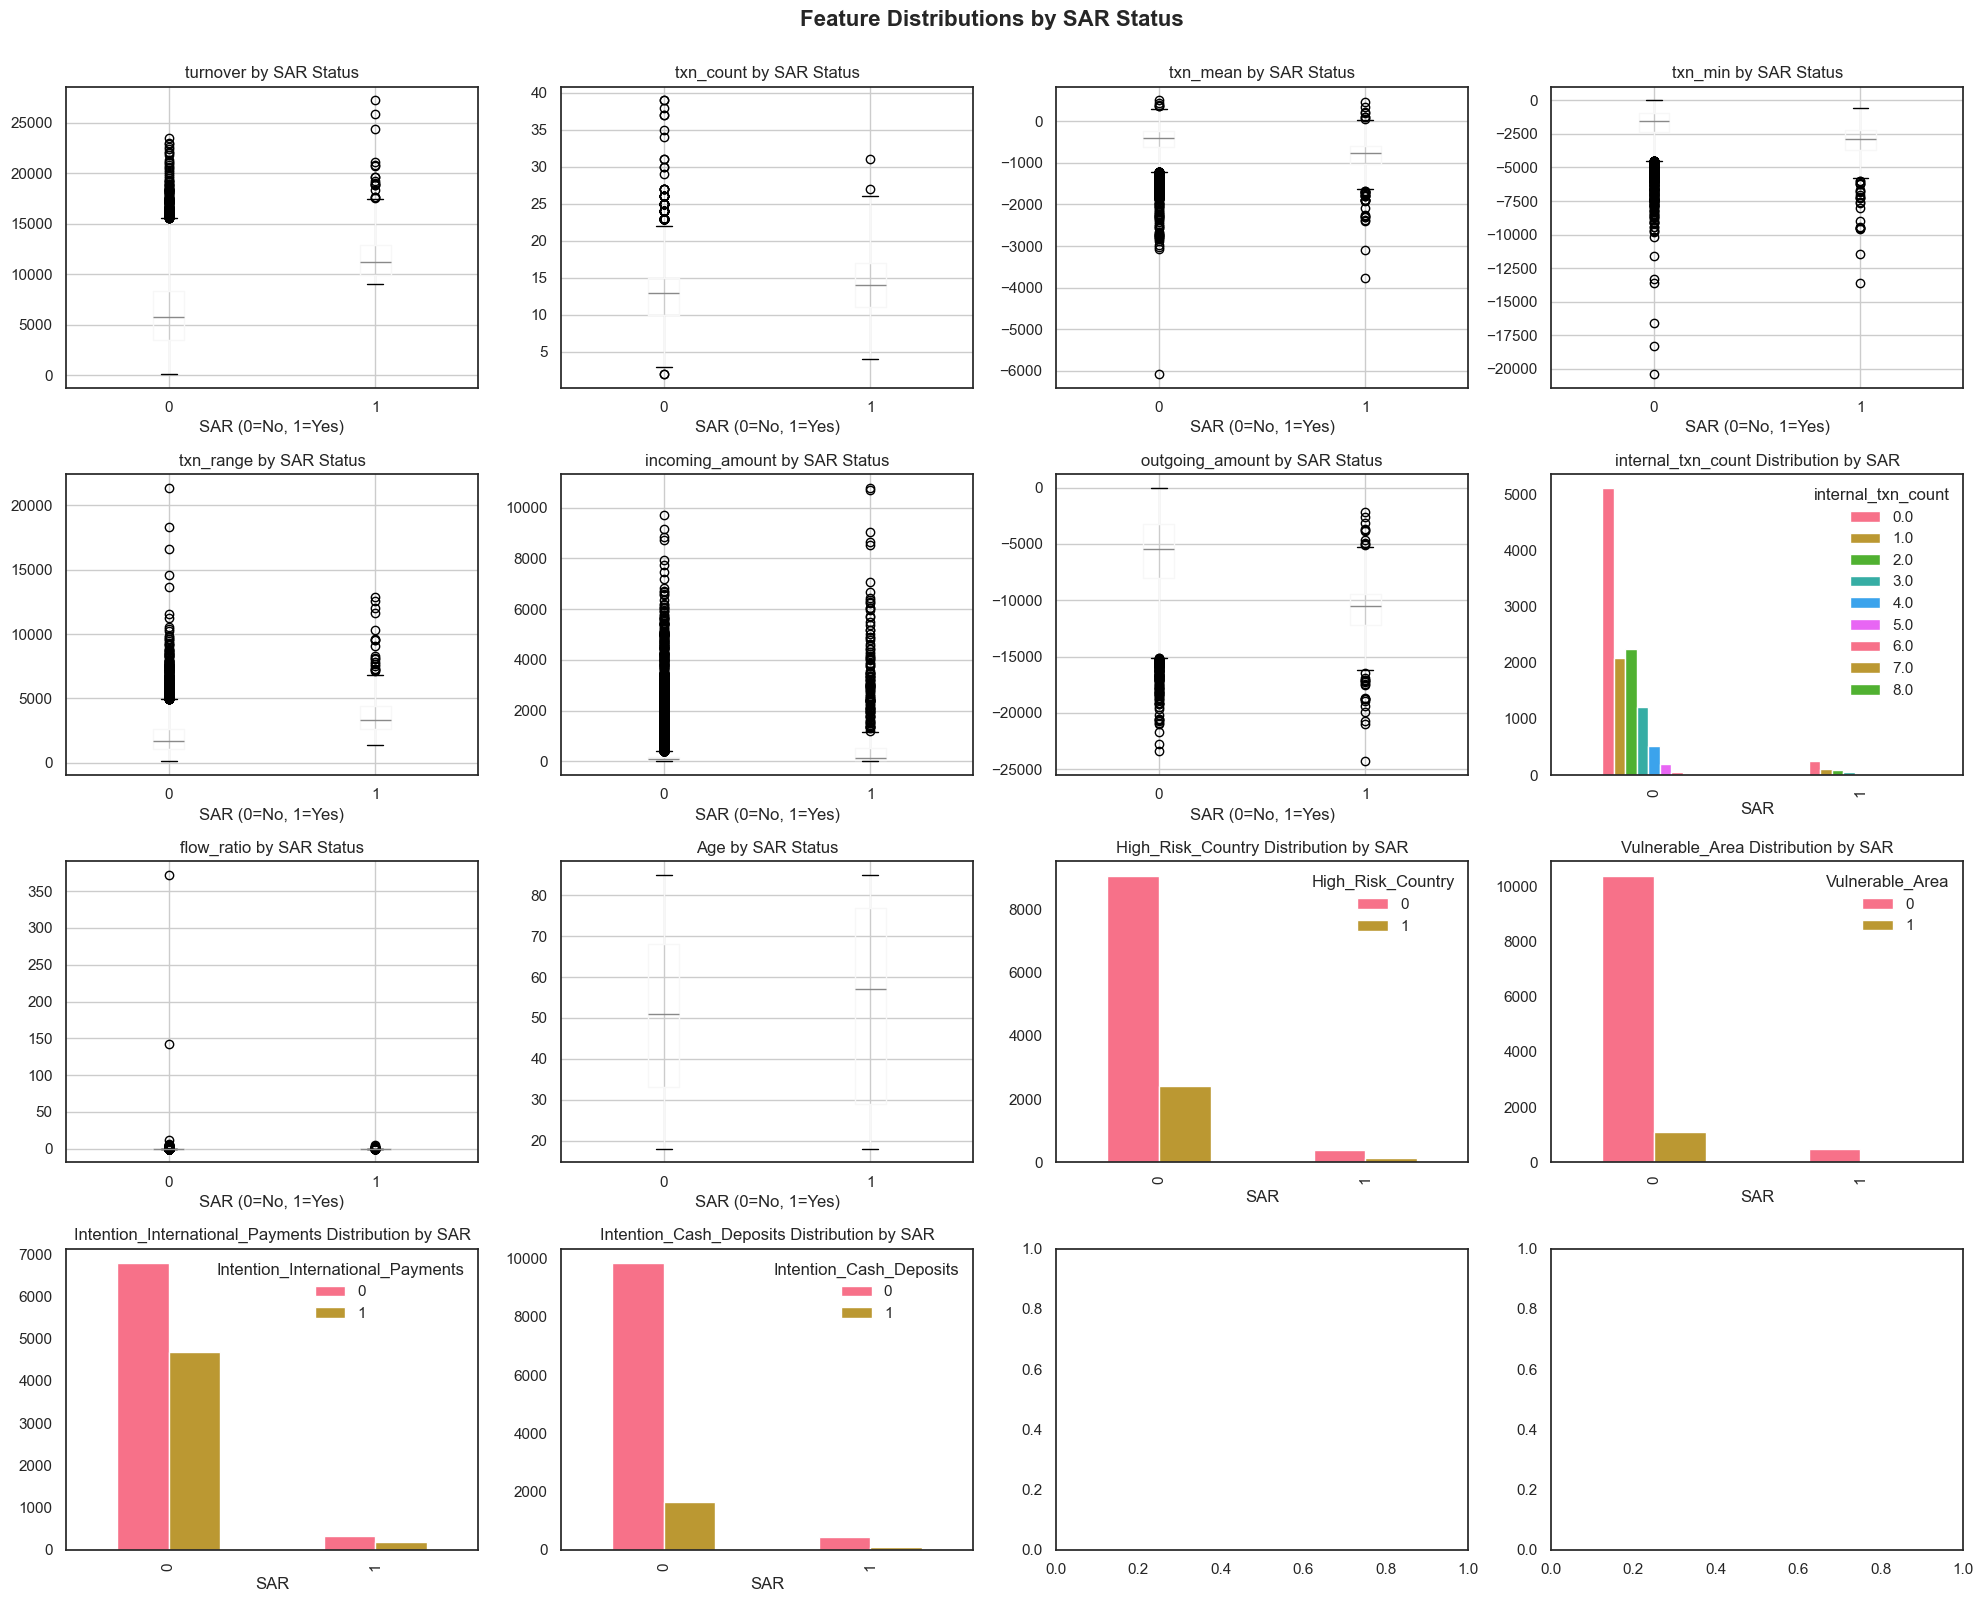

In [47]:
# Visualize key features by SAR status
fig, axes = plt.subplots(4, 4, figsize=(20, 16))  # 16 subplots
axes = axes.flatten()

features_to_plot = ['turnover', 'txn_count', 'txn_mean', 'txn_min', 'txn_range', 'incoming_amount', 
                    'outgoing_amount', 'internal_txn_count', 'flow_ratio', 
                    'Age', 'High_Risk_Country', 'Vulnerable_Area', 'Intention_International_Payments', 
                    'Intention_Cash_Deposits']

for idx, feature in enumerate(features_to_plot):
    if feature in df_complete.columns:
        # Box plot for continuous variables
        if df_complete[feature].nunique() > 10:
            df_complete.boxplot(column=feature, by='SAR', ax=axes[idx])
            axes[idx].set_title(f'{feature} by SAR Status')
            axes[idx].set_xlabel('SAR (0=No, 1=Yes)')
        else:
            # Bar plot for categorical/binary variables
            df_complete.groupby(['SAR', feature]).size().unstack(fill_value=0).plot(kind='bar', ax=axes[idx])
            axes[idx].set_title(f'{feature} Distribution by SAR')
            axes[idx].set_xlabel('SAR')
            axes[idx].legend(title=feature)

plt.suptitle('Feature Distributions by SAR Status', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

## Current Rule Performance Analysis (€9,000 Threshold)

CURRENT RULE PERFORMANCE: Turnover > €9,000

Confusion Matrix:
True Negatives (TN):  9,202
False Positives (FP): 2,273
False Negatives (FN): 0
True Positives (TP):  525

Metric                    Value     
-----------------------------------
Precision                 0.1876
Recall (Detection Rate)   1.0000
F1-Score                  0.3160
False Positive Rate       0.1981
Customers Flagged         2,798
% of Customers Flagged    23.32%

SAR Detection             Count     
-----------------------------------
Total SARs                525
Detected by Rule          525
Missed by Rule            0
Detection Rate            100.00%


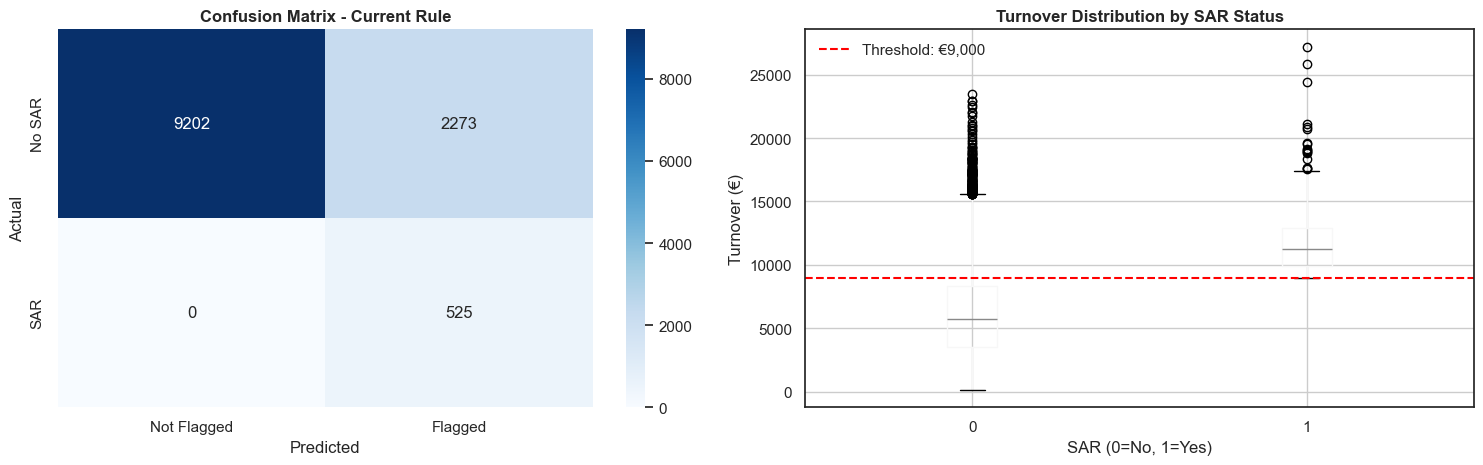

In [48]:
# Evaluate current rule: turnover > 9000 EUR
threshold = 9000
df_complete['current_rule_flag'] = (df_complete['turnover'] > threshold).astype(int)

# Calculate metrics
from sklearn.metrics import confusion_matrix, classification_report

print("=" * 80)
print(f"CURRENT RULE PERFORMANCE: Turnover > €{threshold:,}")
print("=" * 80)

# Confusion matrix
cm = confusion_matrix(df_complete['SAR'], df_complete['current_rule_flag'])
tn, fp, fn, tp = cm.ravel()

print(f"\nConfusion Matrix:")
print(f"True Negatives (TN):  {tn:,}")
print(f"False Positives (FP): {fp:,}")
print(f"False Negatives (FN): {fn:,}")
print(f"True Positives (TP):  {tp:,}")

# Calculate metrics
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
fpr = fp / (fp + tn) if (fp + tn) > 0 else 0

print(f"\n{'Metric':<25} {'Value':<10}")
print("-" * 35)
print(f"{'Precision':<25} {precision:.4f}")
print(f"{'Recall (Detection Rate)':<25} {recall:.4f}")
print(f"{'F1-Score':<25} {f1:.4f}")
print(f"{'False Positive Rate':<25} {fpr:.4f}")
print(f"{'Customers Flagged':<25} {(fp + tp):,}")
print(f"{'% of Customers Flagged':<25} {((fp + tp) / len(df_complete) * 100):.2f}%")

# Additional insights
total_sars = df_complete['SAR'].sum()
detected_sars = tp
missed_sars = fn

print(f"\n{'SAR Detection':<25} {'Count':<10}")
print("-" * 35)
print(f"{'Total SARs':<25} {total_sars:,}")
print(f"{'Detected by Rule':<25} {detected_sars:,}")
print(f"{'Missed by Rule':<25} {missed_sars:,}")
print(f"{'Detection Rate':<25} {(detected_sars/total_sars*100):.2f}%")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Confusion Matrix Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], 
            xticklabels=['Not Flagged', 'Flagged'], 
            yticklabels=['No SAR', 'SAR'])
axes[0].set_title('Confusion Matrix - Current Rule', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Predicted')

# Turnover distribution by SAR
df_complete.boxplot(column='turnover', by='SAR', ax=axes[1])
axes[1].axhline(y=threshold, color='red', linestyle='--', label=f'Threshold: €{threshold:,}')
axes[1].set_title('Turnover Distribution by SAR Status', fontsize=12, fontweight='bold')
axes[1].set_xlabel('SAR (0=No, 1=Yes)')
axes[1].set_ylabel('Turnover (€)')
axes[1].legend()
plt.suptitle('')

plt.tight_layout()
plt.show()

## Machine Learning Model Development

### Prepare data for modeling

In [22]:
df_complete.columns

Index(['Customer_ID', 'Month', 'txn_count', 'txn_sum', 'txn_mean', 'txn_std',
       'txn_min', 'txn_max', 'turnover', 'incoming_count', 'outgoing_count',
       'incoming_amount', 'outgoing_amount', 'internal_txn_count', 'txn_range',
       'flow_ratio', 'internal_txn_ratio', 'SAR', 'Age', 'Sex',
       'High_Risk_Country', 'Vulnerable_Area',
       'Intention_International_Payments', 'Intention_Cash_Deposits',
       'current_rule_flag'],
      dtype='object')

In [ ]:
# Select features including new behavioral mismatch features
feature_columns = ['txn_count', 'txn_mean', 'txn_min', 'txn_range', 'turnover',
                   'incoming_count', 'outgoing_count', 'incoming_amount', 'outgoing_amount',
                   'internal_txn_count', 'txn_range', 'flow_ratio', 'internal_txn_ratio',
                   'cash_txn_count', 'cash_txn_amount', 'intl_txn_count', 'intl_txn_amount',
                   'cash_mismatch', 'cash_mismatch_count', 'cash_mismatch_amount',
                   'intl_mismatch', 'intl_mismatch_count', 'intl_mismatch_amount',
                   'Age', 'Sex', 'High_Risk_Country', 'Vulnerable_Area',
                   'Intention_International_Payments', 'Intention_Cash_Deposits']

X = df_complete[feature_columns].copy()
y = df_complete['SAR'].copy()

# Handle any remaining NaN values
X = X.fillna(0)

# Handle infinite values
X = X.replace([np.inf, -np.inf], 0)

print("=" * 80)
print("DATA PREPARATION FOR MODELING")
print("=" * 80)
print(f"Feature matrix shape: {X.shape}")
print(f"Target variable shape: {y.shape}")
print(f"Number of features: {len(feature_columns)}")
print(f"\nClass distribution:")
print(y.value_counts())
print(f"\nClass imbalance ratio: {(y==0).sum() / (y==1).sum():.1f}:1")

# Split data - using stratified split to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nTraining set SAR rate: {y_train.mean()*100:.2f}%")
print(f"Test set SAR rate: {y_test.mean()*100:.2f}%")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nFeatures scaled using StandardScaler")

DATA PREPARATION FOR MODELING
Feature matrix shape: (12000, 19)
Target variable shape: (12000,)
Number of features: 19

Class distribution:
SAR
0    11475
1      525
Name: count, dtype: int64

Class imbalance ratio: 21.9:1

Training set: 9600 samples
Test set: 2400 samples

Training set SAR rate: 4.38%
Test set SAR rate: 4.38%

Features scaled using StandardScaler


### Model 1: Logistic Regression

MODEL 1: LOGISTIC REGRESSION

Classification Report:
              precision    recall  f1-score   support

      No SAR       0.99      0.82      0.90      2295
         SAR       0.18      0.89      0.30       105

    accuracy                           0.82      2400
   macro avg       0.59      0.85      0.60      2400
weighted avg       0.96      0.82      0.87      2400


Confusion Matrix:
[[1880  415]
 [  12   93]]

ROC-AUC Score: 0.8993
AUC-PR (Average Precision): 0.2043

Top 10 Most Important Features (by coefficient magnitude):
                             Feature  Coefficient
4                           turnover     1.139996
8                    outgoing_amount    -1.095345
7                    incoming_amount     0.358857
1                           txn_mean    -0.343009
16                   Vulnerable_Area    -0.226832
2                            txn_min     0.210164
12                internal_txn_ratio    -0.096821
5                     incoming_count     0.085117
17  In

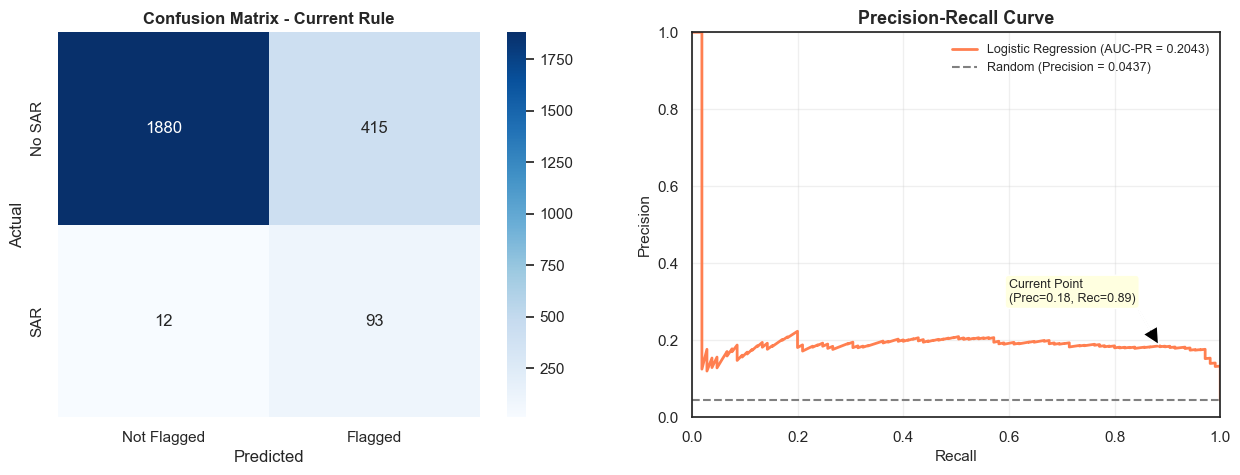

In [50]:
# Model 1: Logistic Regression with class weights
print("=" * 80)
print("MODEL 1: LOGISTIC REGRESSION")
print("=" * 80)

# Calculate class weights to handle imbalance
class_weight_ratio = (y_train == 0).sum() / (y_train == 1).sum()
class_weights = {0: 1, 1: class_weight_ratio}

lr_model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
lr_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_proba_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

# Evaluation
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr, target_names=['No SAR', 'SAR']))

# Confusion Matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
print("\nConfusion Matrix:")
print(cm_lr)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Confusion Matrix Heatmap
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=axes[0], 
            xticklabels=['Not Flagged', 'Flagged'], 
            yticklabels=['No SAR', 'SAR'])
axes[0].set_title('Confusion Matrix - Current Rule', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Predicted')

# ROC-AUC
roc_auc_lr = roc_auc_score(y_test, y_pred_proba_lr)
print(f"\nROC-AUC Score: {roc_auc_lr:.4f}")

# Compute AUC-PR (also called Average Precision)
auc_pr = average_precision_score(y_test, y_pred_proba_lr)
print(f"AUC-PR (Average Precision): {auc_pr:.4f}")

# Visualize PR Curve
# Compute PR curve points
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_lr)

# Plot on axes[1]
axes[1].plot(recall, precision, color='coral', linewidth=2,
             label=f'Logistic Regression (AUC-PR = {auc_pr:.4f})')

# Baseline: random classifier = prevalence of SAR in test set
baseline = y_test.mean()  # ~0.04375
axes[1].axhline(y=baseline, color='gray', linestyle='--',
                label=f'Random (Precision = {baseline:.4f})')

# Customize plot
axes[1].set_xlabel('Recall', fontsize=11)
axes[1].set_ylabel('Precision', fontsize=11)
axes[1].set_title('Precision-Recall Curve', fontweight='bold', fontsize=13)
axes[1].legend(loc='lower left', fontsize=9)
axes[1].grid(alpha=0.3)
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.0])
legend = axes[1].legend(loc='upper right', fontsize=9)

# Add text annotation for current operating point
current_prec = precision_score(y_test, y_pred_lr)  # from classification report
current_rec = recall_score(y_test, y_pred_lr)
axes[1].annotate(f'Current Point\n(Prec={current_prec:.2f}, Rec={current_rec:.2f})',
                 xy=(current_rec, current_prec),
                 xytext=(0.6, 0.3),
                 arrowprops=dict(facecolor='black', shrink=0.05, width=1),
                 fontsize=9, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow"))

# Feature importance (coefficients)
feature_importance_lr = pd.DataFrame({
    'Feature': feature_columns,
    'Coefficient': lr_model.coef_[0]
}).sort_values('Coefficient', key=abs, ascending=False)

print("\nTop 10 Most Important Features (by coefficient magnitude):")
print(feature_importance_lr.head(20))

### Model 2: Random Forest Classifier

In [59]:
np.bincount(y)

array([11475,   525])

MODEL 2: RANDOM FOREST

Classification Report:
              precision    recall  f1-score   support

      No SAR       0.99      0.84      0.91      2295
         SAR       0.19      0.82      0.31       105

    accuracy                           0.84      2400
   macro avg       0.59      0.83      0.61      2400
weighted avg       0.96      0.84      0.88      2400


Confusion Matrix:
[[1936  359]
 [  19   86]]

ROC-AUC Score: 0.9166
AUC-PR (Average Precision): 0.3128

Top 10 Most Important Features:
                             Feature  Importance
4                           turnover    0.325934
8                    outgoing_amount    0.264263
3                          txn_range    0.081513
2                            txn_min    0.078005
10                         txn_range    0.062556
1                           txn_mean    0.056226
7                    incoming_amount    0.035135
11                        flow_ratio    0.022810
13                               Age    0.021544

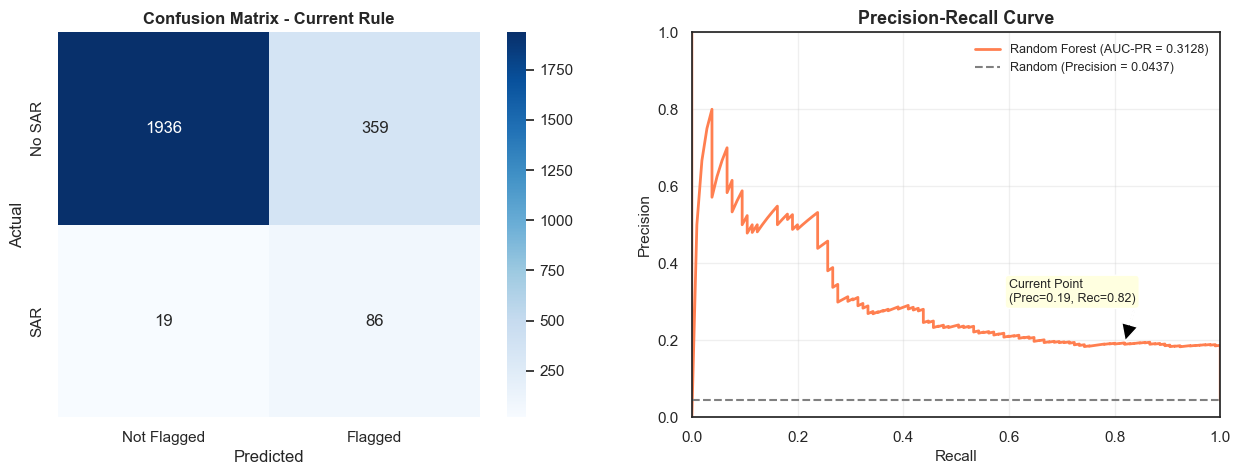

In [51]:
# Model 2: Random Forest Classifier
print("=" * 80)
print("MODEL 2: RANDOM FOREST")
print("=" * 80)

rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=20, 
                                   class_weight='balanced', random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Evaluation
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=['No SAR', 'SAR']))

# Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
print("\nConfusion Matrix:")
print(cm_rf)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Confusion Matrix Heatmap
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=axes[0], 
            xticklabels=['Not Flagged', 'Flagged'], 
            yticklabels=['No SAR', 'SAR'])
axes[0].set_title('Confusion Matrix - Current Rule', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Predicted')

# ROC-AUC
roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
print(f"\nROC-AUC Score: {roc_auc_rf:.4f}")

# Compute AUC-PR (also called Average Precision)
auc_pr = average_precision_score(y_test, y_pred_proba_rf)
print(f"AUC-PR (Average Precision): {auc_pr:.4f}")

# Visualize PR Curve
# Compute PR curve points
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_rf)

# Plot on axes[1]
axes[1].plot(recall, precision, color='coral', linewidth=2,
             label=f'Random Forest (AUC-PR = {auc_pr:.4f})')

# Baseline: random classifier = prevalence of SAR in test set
baseline = y_test.mean()  # ~0.04375
axes[1].axhline(y=baseline, color='gray', linestyle='--',
                label=f'Random (Precision = {baseline:.4f})')

# Customize plot
axes[1].set_xlabel('Recall', fontsize=11)
axes[1].set_ylabel('Precision', fontsize=11)
axes[1].set_title('Precision-Recall Curve', fontweight='bold', fontsize=13)
axes[1].legend(loc='lower left', fontsize=9)
axes[1].grid(alpha=0.3)
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.0])

# Fix legend: move text away from line
legend = axes[1].legend(loc='upper right', fontsize=9)
        
# Add text annotation for current operating point
current_prec = precision_score(y_test, y_pred_rf)  # from classification report
current_rec = recall_score(y_test, y_pred_rf)
axes[1].annotate(f'Current Point\n(Prec={current_prec:.2f}, Rec={current_rec:.2f})',
                 xy=(current_rec, current_prec),
                 xytext=(0.6, 0.3),
                 arrowprops=dict(facecolor='black', shrink=0.05, width=1),
                 fontsize=9, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow"))

# Feature importance
feature_importance_rf = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance_rf.head(20))

In [57]:
86/(359+86)

0.19325842696629214

## Model Comparison and Evaluation

In [52]:
# Compare all models including baseline
print("=" * 80)
print("MODEL COMPARISON SUMMARY")
print("=" * 80)

# Calculate metrics for all models
models = {
    'Current Rule (€9k)': {
        'predictions': df_complete.loc[X_test.index, 'current_rule_flag'],
        'probabilities': None
    },
    'Logistic Regression': {
        'predictions': y_pred_lr,
        'probabilities': y_pred_proba_lr
    },
    'Random Forest': {
        'predictions': y_pred_rf,
        'probabilities': y_pred_proba_rf
    }
}

results = []
for model_name, preds in models.items():
    y_pred = preds['predictions']
    
    # Calculate metrics
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    
    # Calculate confusion matrix elements
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    
    # ROC-AUC (only for models with probabilities)
    roc_auc = roc_auc_score(y_test, preds['probabilities']) if preds['probabilities'] is not None else 'N/A'
    # Compute AUC-PR (also called Average Precision)
    auc_pr = average_precision_score(y_test, preds['probabilities']) if preds['probabilities'] is not None else 'N/A'
    
    results.append({
        'Model': model_name,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc if isinstance(roc_auc, str) else f"{roc_auc:.4f}",
        'AUC-PR': auc_pr if isinstance(auc_pr, str) else f"{auc_pr:.4f}",
        'False Positive Rate': fpr,
        'True Positives': tp,
        'False Positives': fp,
        'False Negatives': fn,
        'True Negatives': tn
    })

results_df = pd.DataFrame(results)
print("\nPerformance Metrics:")
print(results_df.to_string(index=False))

# Key insights
print("\n" + "=" * 80)
print("KEY INSIGHTS")
print("=" * 80)

best_recall_idx = results_df['Recall'].idxmax()
best_precision_idx = results_df['Precision'].idxmax()
best_f1_idx = results_df['F1-Score'].idxmax()

print(f"\n• Best Recall (Detection Rate): {results_df.iloc[best_recall_idx]['Model']} ({results_df.iloc[best_recall_idx]['Recall']:.2%})")
print(f"• Best Precision (Lowest False Positives): {results_df.iloc[best_precision_idx]['Model']} ({results_df.iloc[best_precision_idx]['Precision']:.2%})")
print(f"• Best F1-Score (Balance): {results_df.iloc[best_f1_idx]['Model']} ({results_df.iloc[best_f1_idx]['F1-Score']:.4f})")

MODEL COMPARISON SUMMARY

Performance Metrics:
              Model  Precision   Recall  F1-Score ROC-AUC AUC-PR  False Positive Rate  True Positives  False Positives  False Negatives  True Negatives
 Current Rule (€9k)   0.187166 1.000000  0.315315     N/A    N/A             0.198693             105              456                0            1839
Logistic Regression   0.183071 0.885714  0.303426  0.8993 0.2043             0.180828              93              415               12            1880
      Random Forest   0.193258 0.819048  0.312727  0.9166 0.3128             0.156427              86              359               19            1936

KEY INSIGHTS

• Best Recall (Detection Rate): Current Rule (€9k) (100.00%)
• Best Precision (Lowest False Positives): Random Forest (19.33%)
• Best F1-Score (Balance): Current Rule (€9k) (0.3153)


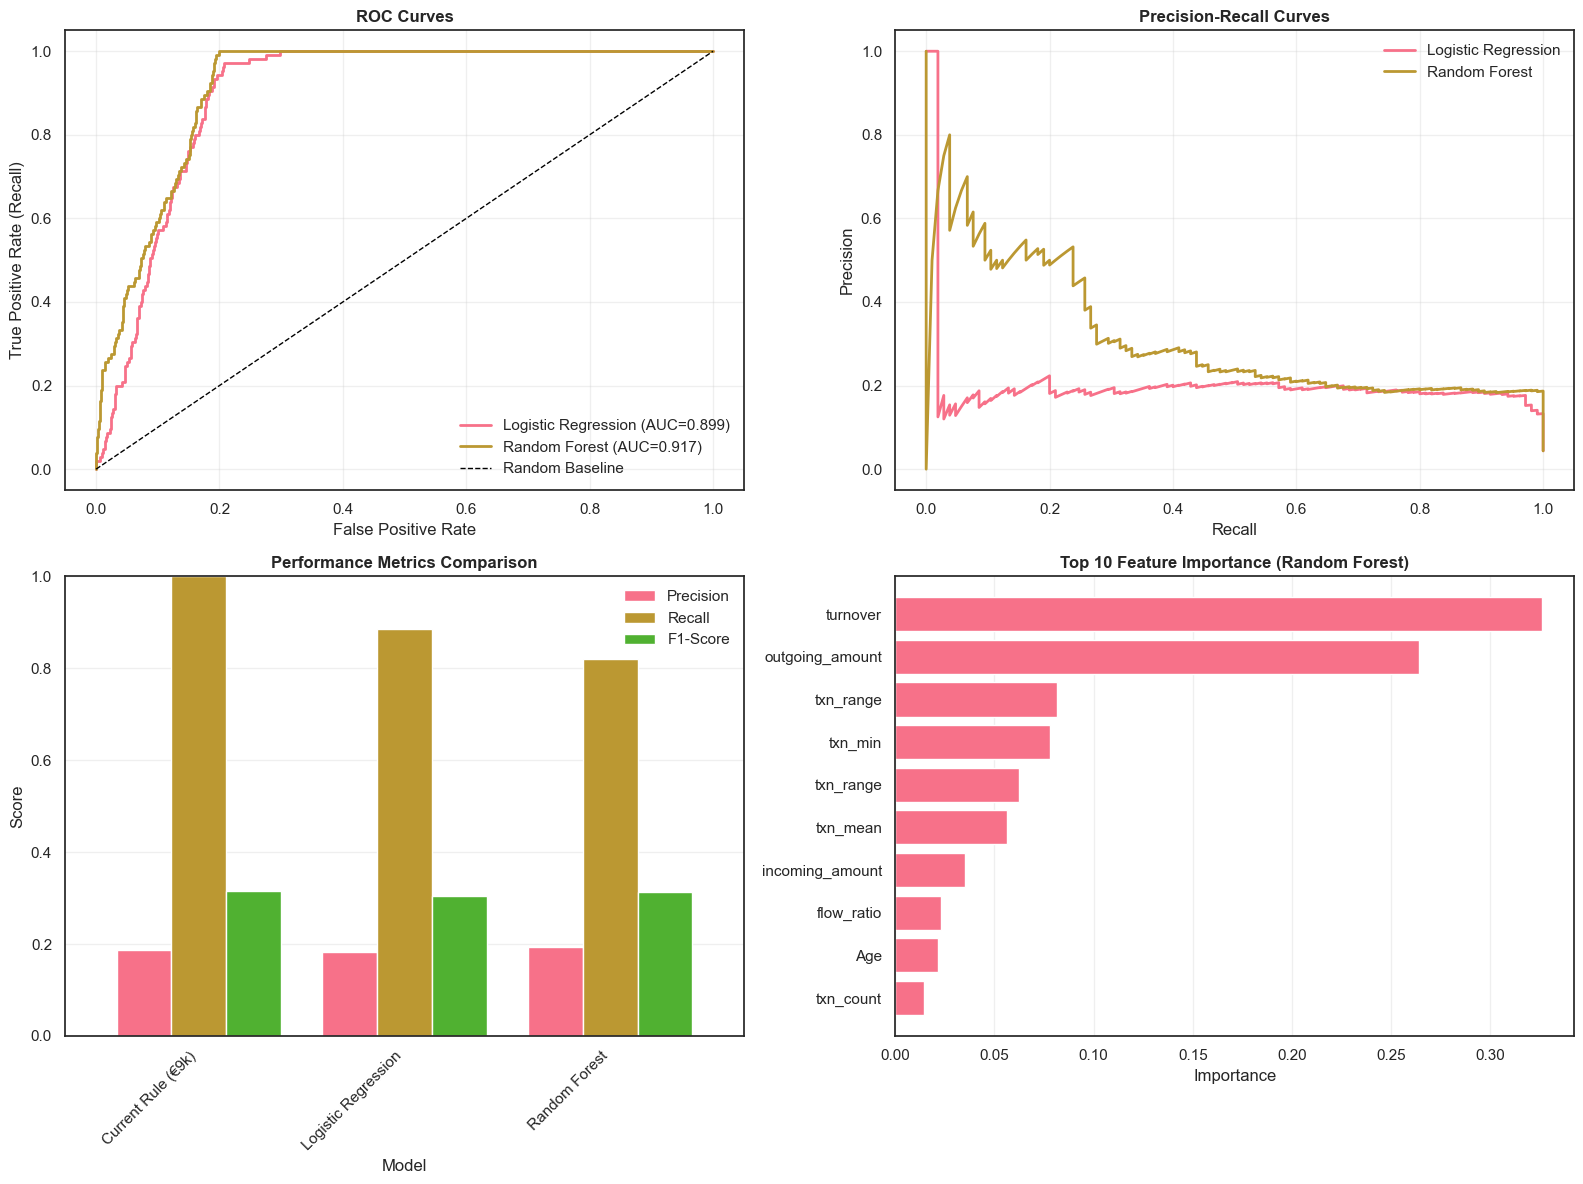

In [53]:
# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. ROC Curves
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)

axes[0, 0].plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC={roc_auc_lr:.3f})', linewidth=2)
axes[0, 0].plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC={roc_auc_rf:.3f})', linewidth=2)
axes[0, 0].plot([0, 1], [0, 1], 'k--', label='Random Baseline', linewidth=1)
axes[0, 0].set_xlabel('False Positive Rate')
axes[0, 0].set_ylabel('True Positive Rate (Recall)')
axes[0, 0].set_title('ROC Curves', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Precision-Recall Curves
precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_pred_proba_lr)
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_pred_proba_rf)

axes[0, 1].plot(recall_lr, precision_lr, label='Logistic Regression', linewidth=2)
axes[0, 1].plot(recall_rf, precision_rf, label='Random Forest', linewidth=2)
axes[0, 1].set_xlabel('Recall')
axes[0, 1].set_ylabel('Precision')
axes[0, 1].set_title('Precision-Recall Curves', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 3. Metrics Comparison Bar Chart
metrics_comparison = results_df[['Model', 'Precision', 'Recall', 'F1-Score']].copy()
metrics_comparison = metrics_comparison.set_index('Model')
metrics_comparison.plot(kind='bar', ax=axes[1, 0], width=0.8)
axes[1, 0].set_title('Performance Metrics Comparison', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Score')
axes[1, 0].set_ylim([0, 1])
axes[1, 0].legend(loc='upper right')
axes[1, 0].grid(alpha=0.3, axis='y')
axes[1, 0].set_xticklabels(metrics_comparison.index, rotation=45, ha='right')

# 4. Feature Importance (Random Forest)
top_features = feature_importance_rf.head(10)
axes[1, 1].barh(range(len(top_features)), top_features['Importance'])
axes[1, 1].set_yticks(range(len(top_features)))
axes[1, 1].set_yticklabels(top_features['Feature'])
axes[1, 1].set_xlabel('Importance')
axes[1, 1].set_title('Top 10 Feature Importance (Random Forest)', fontsize=12, fontweight='bold')
axes[1, 1].invert_yaxis()
axes[1, 1].grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

In [29]:
# Save the trained model and scaler for deployment
import pickle

# Save Random Forest model
with open('rf_sar_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)

# Save feature scaler (if needed for scaled features)
with open('feature_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Save feature names
with open('feature_names.pkl', 'wb') as f:
    pickle.dump(feature_columns, f)

print("Model artifacts saved successfully!")
print("- rf_sar_model.pkl: Trained Random Forest model")
print("- feature_scaler.pkl: Feature scaler")
print("- feature_names.pkl: Feature column names")
print("\nThese can be loaded for deployment in production systems.")

Model artifacts saved successfully!
- rf_sar_model.pkl: Trained Random Forest model
- feature_scaler.pkl: Feature scaler
- feature_names.pkl: Feature column names

These can be loaded for deployment in production systems.


In [30]:
import numpy as np    
from sklearn.linear_model import LogisticRegression

x1 = np.random.randn(100)
x2 = 4*np.random.randn(100)
x3 = 0.5*np.random.randn(100)
y = (3 + x1 + x2 + x3 + 0.2*np.random.randn()) > 0
X = np.column_stack([x1, x2, x3])

m = LogisticRegression()
m.fit(X, y)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [31]:
# The estimated coefficients will all be around 1:
print(m.coef_[0])

[1.08516551 1.95345555 0.90846053]


In [6]:
print(np.array(np.std(X, 0))*m.coef_)

[[1.24232592 6.99863856 0.32761509]]


In [7]:
m.fit(X / np.std(X, 0), y)
print(m.coef_)

[[0.81494472 3.22694125 0.10721455]]
